In [9]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import Simulation, combine_simulations, visualize, visualize_simple, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity
import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

We simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [10]:
config = load_config('../config.yaml')

# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']

## Similarity vs epochs

We here want to analyse the evolution of the dissimilarity as a function of the epochs

### basic network geometries

Here are the basic patterns

In [11]:
simulation_curve = Simulation(num_samples, num_steps, dt)
pattern_curve = lorenz_parameters['one_attractor'][1]
simulation_curve.simulation_lorenz(pattern_curve)

simulation_two_stable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters['two_stable_attractors'][0]
simulation_two_stable_0.simulation_lorenz(pattern_two_stable)

simulation_two_stable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][1]
simulation_two_stable_1.simulation_lorenz(pattern_two_stable)

simulation_two_stable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][2]
simulation_two_stable_2.simulation_lorenz(pattern_two_stable)

simulation_two_unstable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][0]
simulation_two_unstable_0.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][1]
simulation_two_unstable_1.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][2]
simulation_two_unstable_2.simulation_lorenz(pattern_two_unstable)

simulations = {
    "curve": simulation_curve,
    "two_stable_0": simulation_two_stable_0,
    "two_stable_1": simulation_two_stable_1,
    "two_stable_2": simulation_two_stable_2,
    "two_unstable_0": simulation_two_unstable_0,
    "two_unstable_1": simulation_two_unstable_1,
    "two_unstable_2": simulation_two_unstable_2,
}

In [12]:
combined_simulations = {pattern1:{pattern2:{model:{epoch:None for epoch in ['epoch1','epoch2','epoch3']} for model in ['model1','model2','model3']} for pattern2 in simulations.keys() if pattern2 != pattern1} for pattern1 in simulations.keys()}

We now add some perturbations to these patterns. For each pattern, we create $3$ networks, each simulated over $3$ epochs : 
- Pattern + Noise 1 (the Noise strenght get weaker as we move towards later epochs)
- Pattern + Noise 2 (Different Noise levels, but same trend)
- Pattern + Noise 3 + Curve

In [13]:
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        if pattern1 != pattern2:
            for model in combined_simulations[pattern1][pattern2]:
                for epoch in combined_simulations[pattern1][pattern2][model]:
                    simulations[pattern1].perturbation(
                        perturbation_scale=perturbation_scale[model][epoch],
                        model=model,
                        epoch=epoch,
                    )
                    combined_simulations[pattern1][pattern2][model][epoch] = copy.deepcopy(simulations[
                        pattern1
                    ].perturbations_record[model][epoch])
                    if model == 'model3':
                        # add the line attractor
                        if epoch == 'epoch1':
                            mixing_level = 1
                        elif epoch=='epoch2':
                            mixing_level = 0.5
                        elif epoch == 'epoch3':
                            mixing_level = 0.25
                        combined_simulations[pattern1][pattern2][model][epoch] = combine_simulations([copy.deepcopy(simulations[pattern2].simulation),copy.deepcopy(simulations[pattern1].perturbations_record[model][epoch])], method='combine',mixing_level=mixing_level)

### Visualization of random network

We here visualize the 3rd network of the pattern $\text {\it{two stable Lorenz attractors}}$

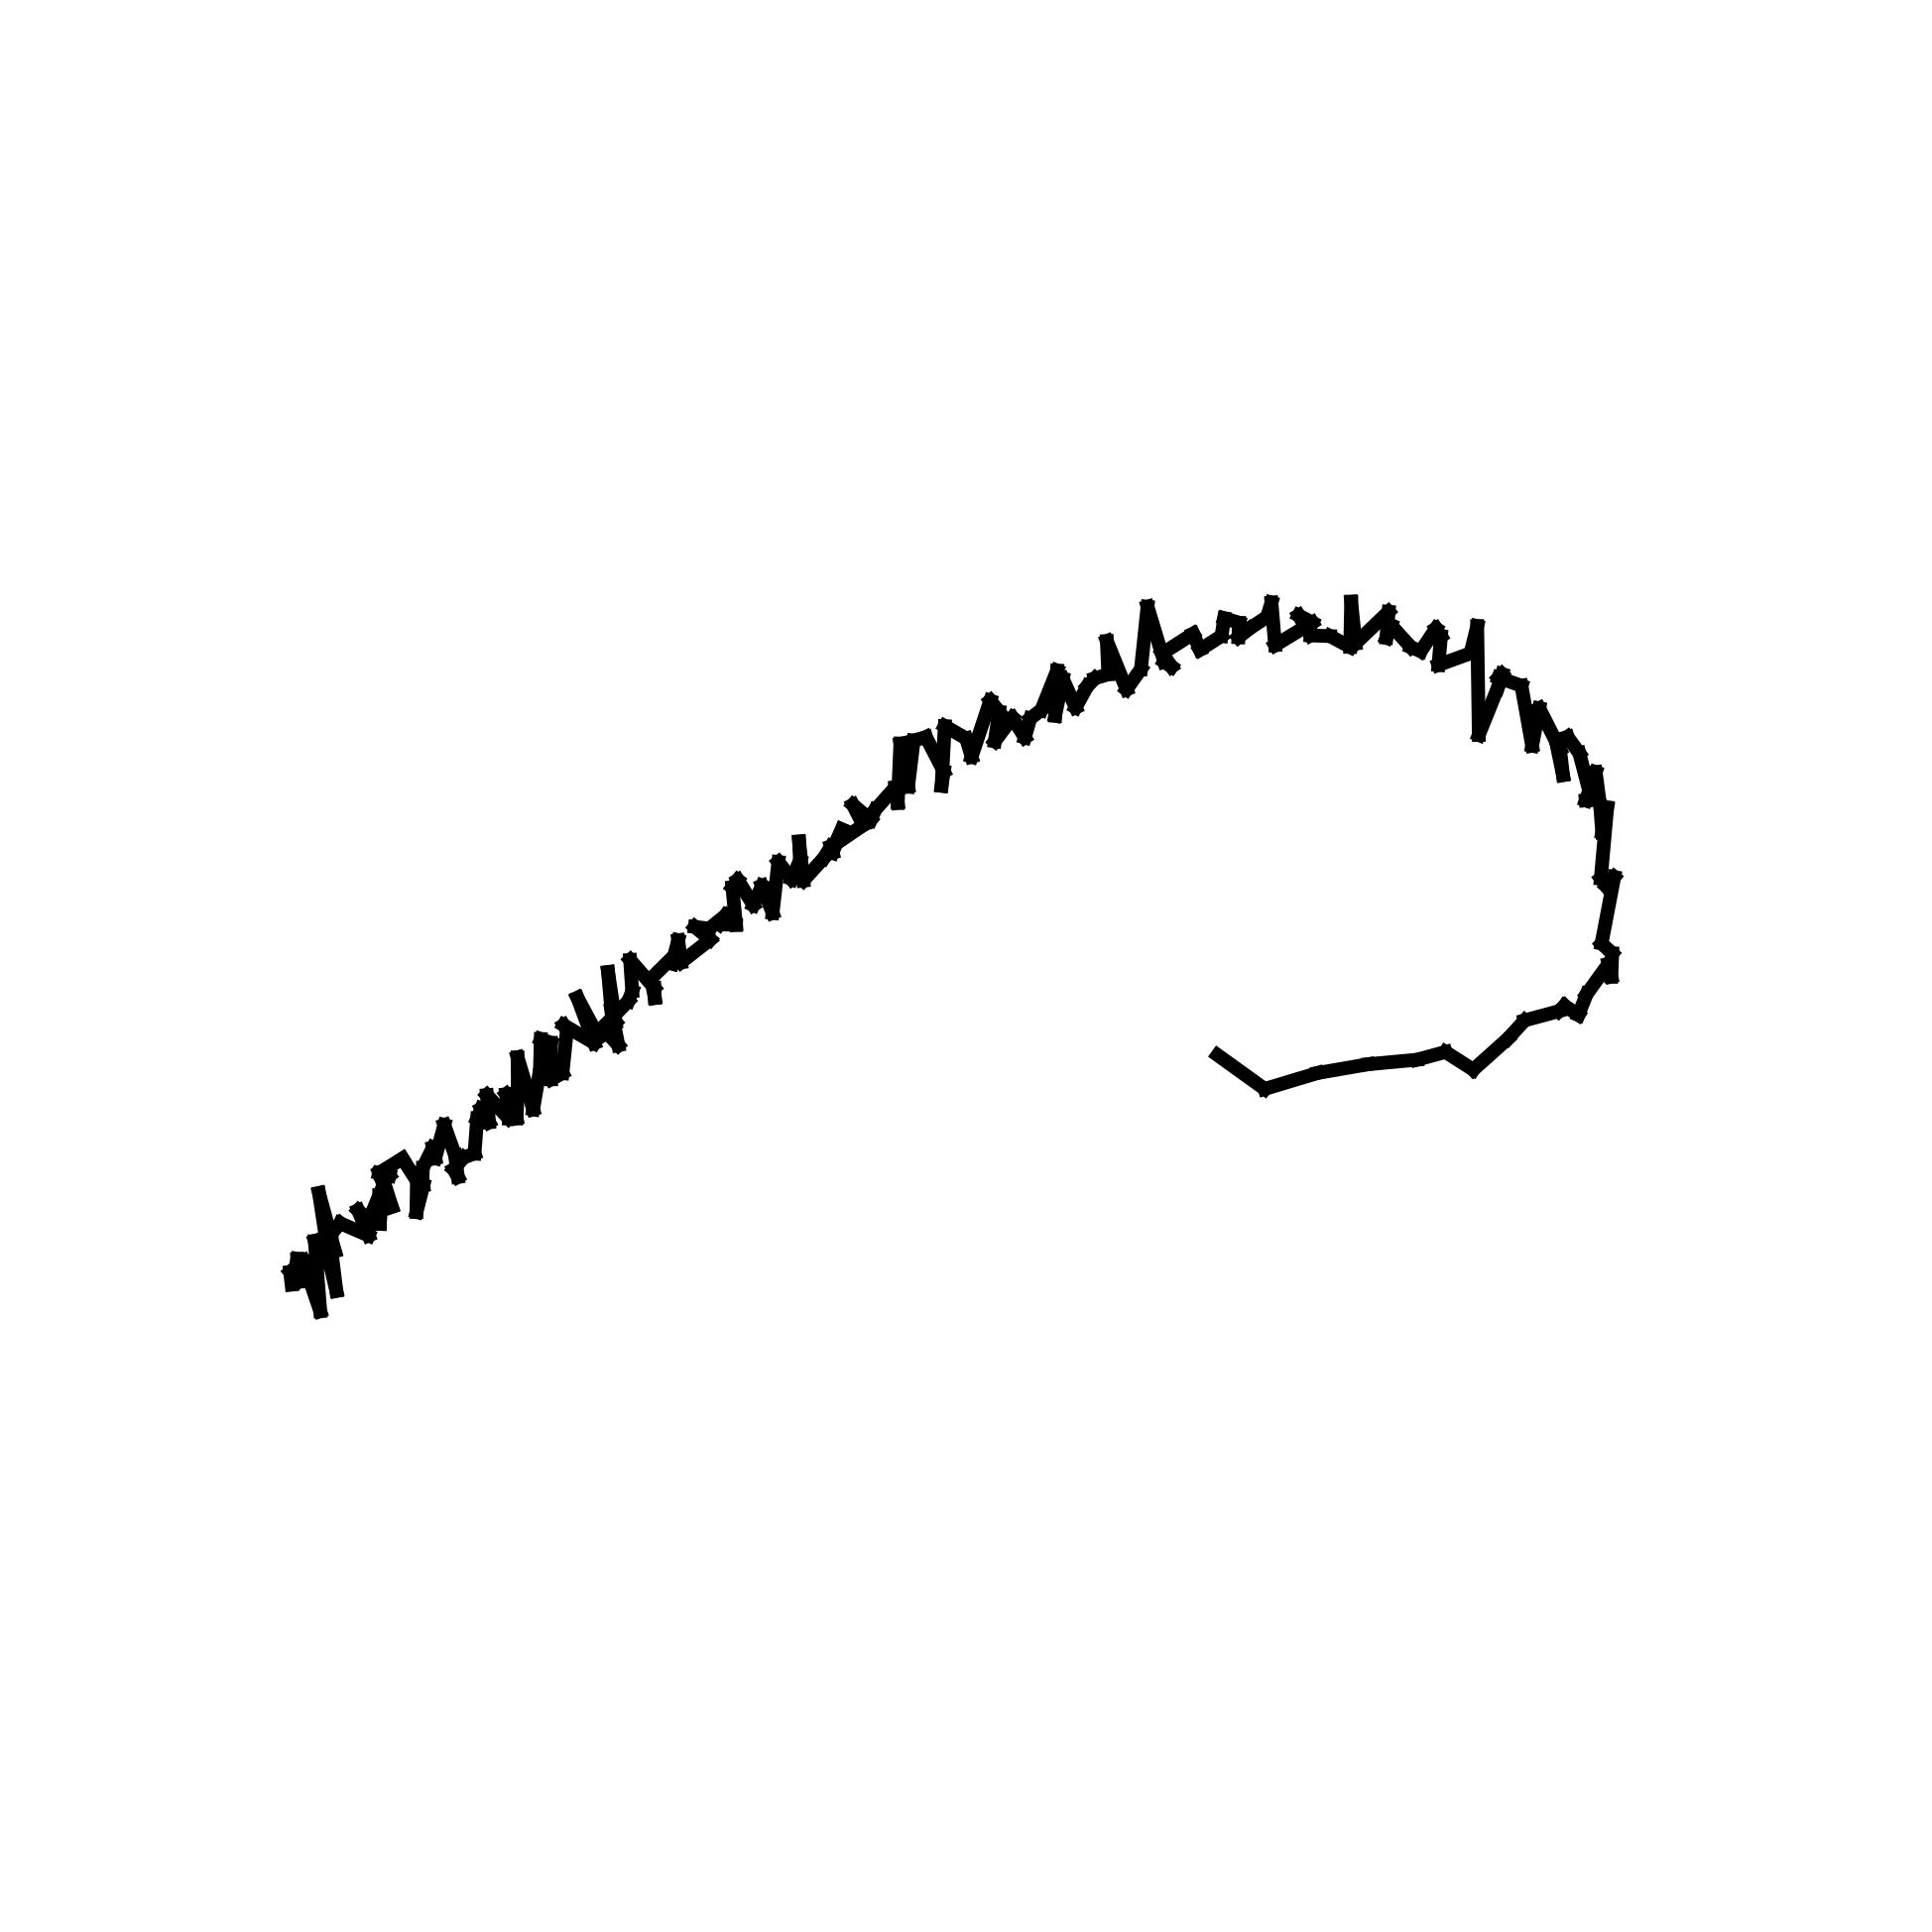

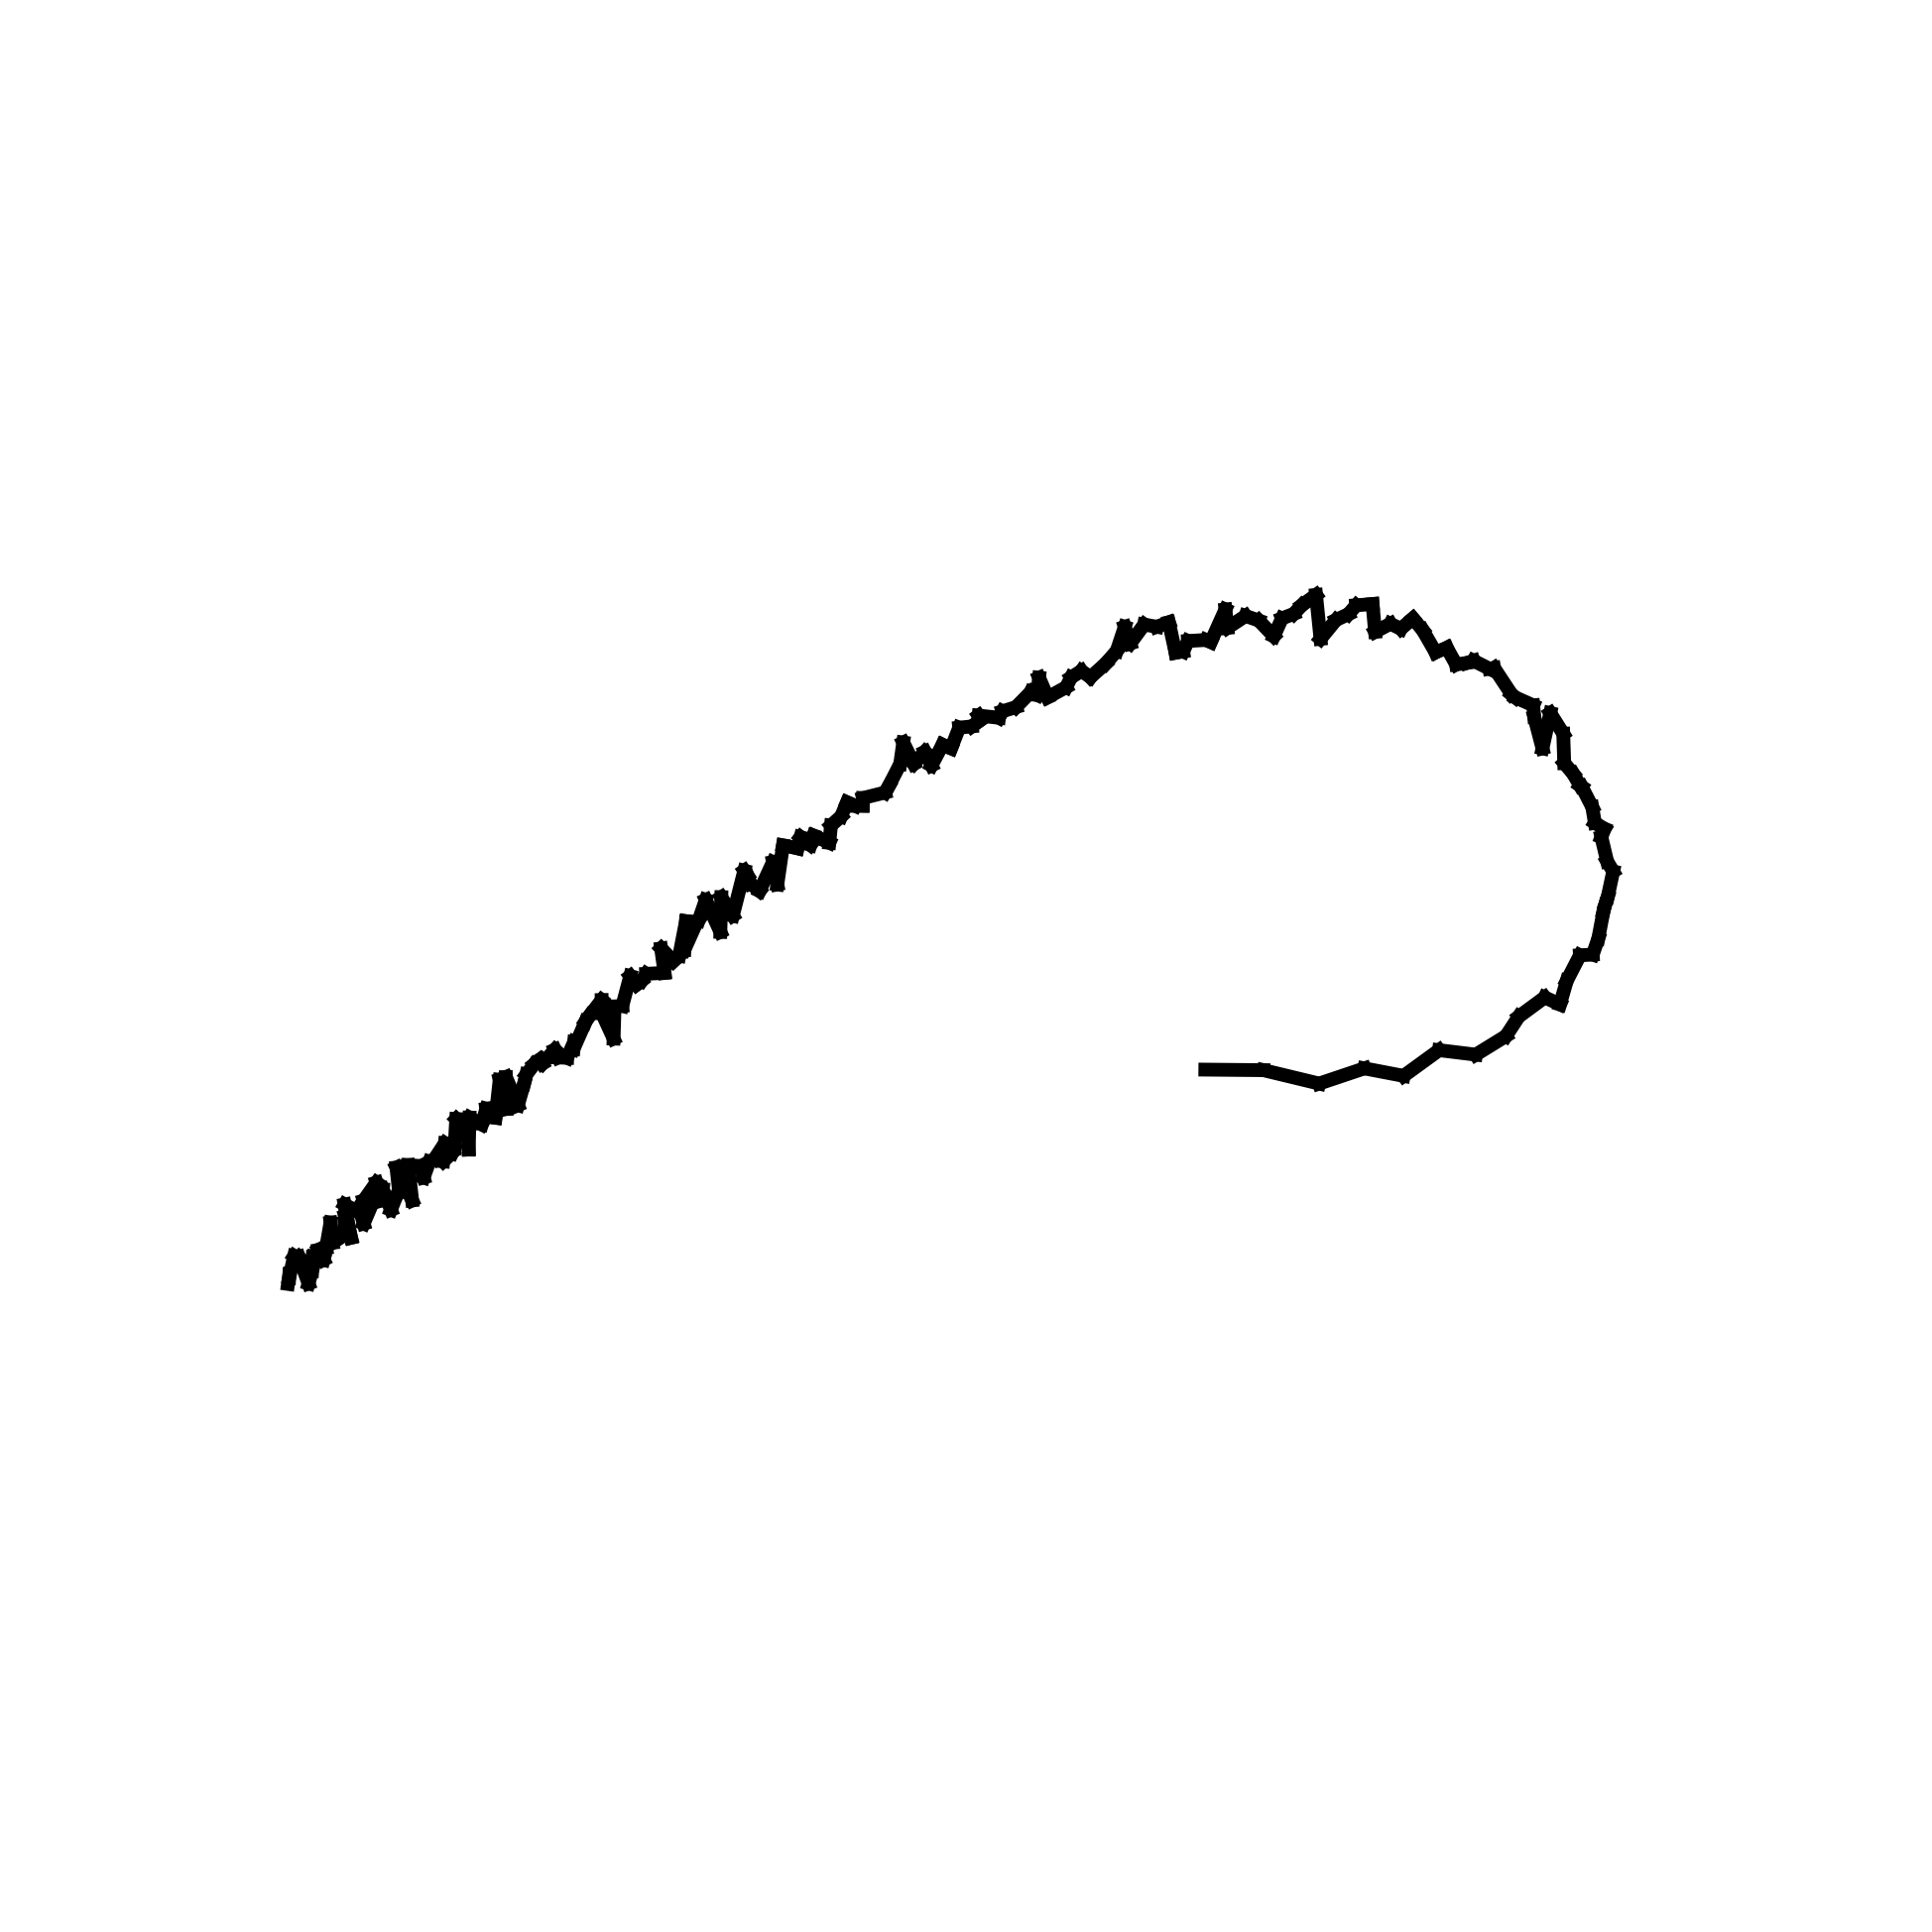

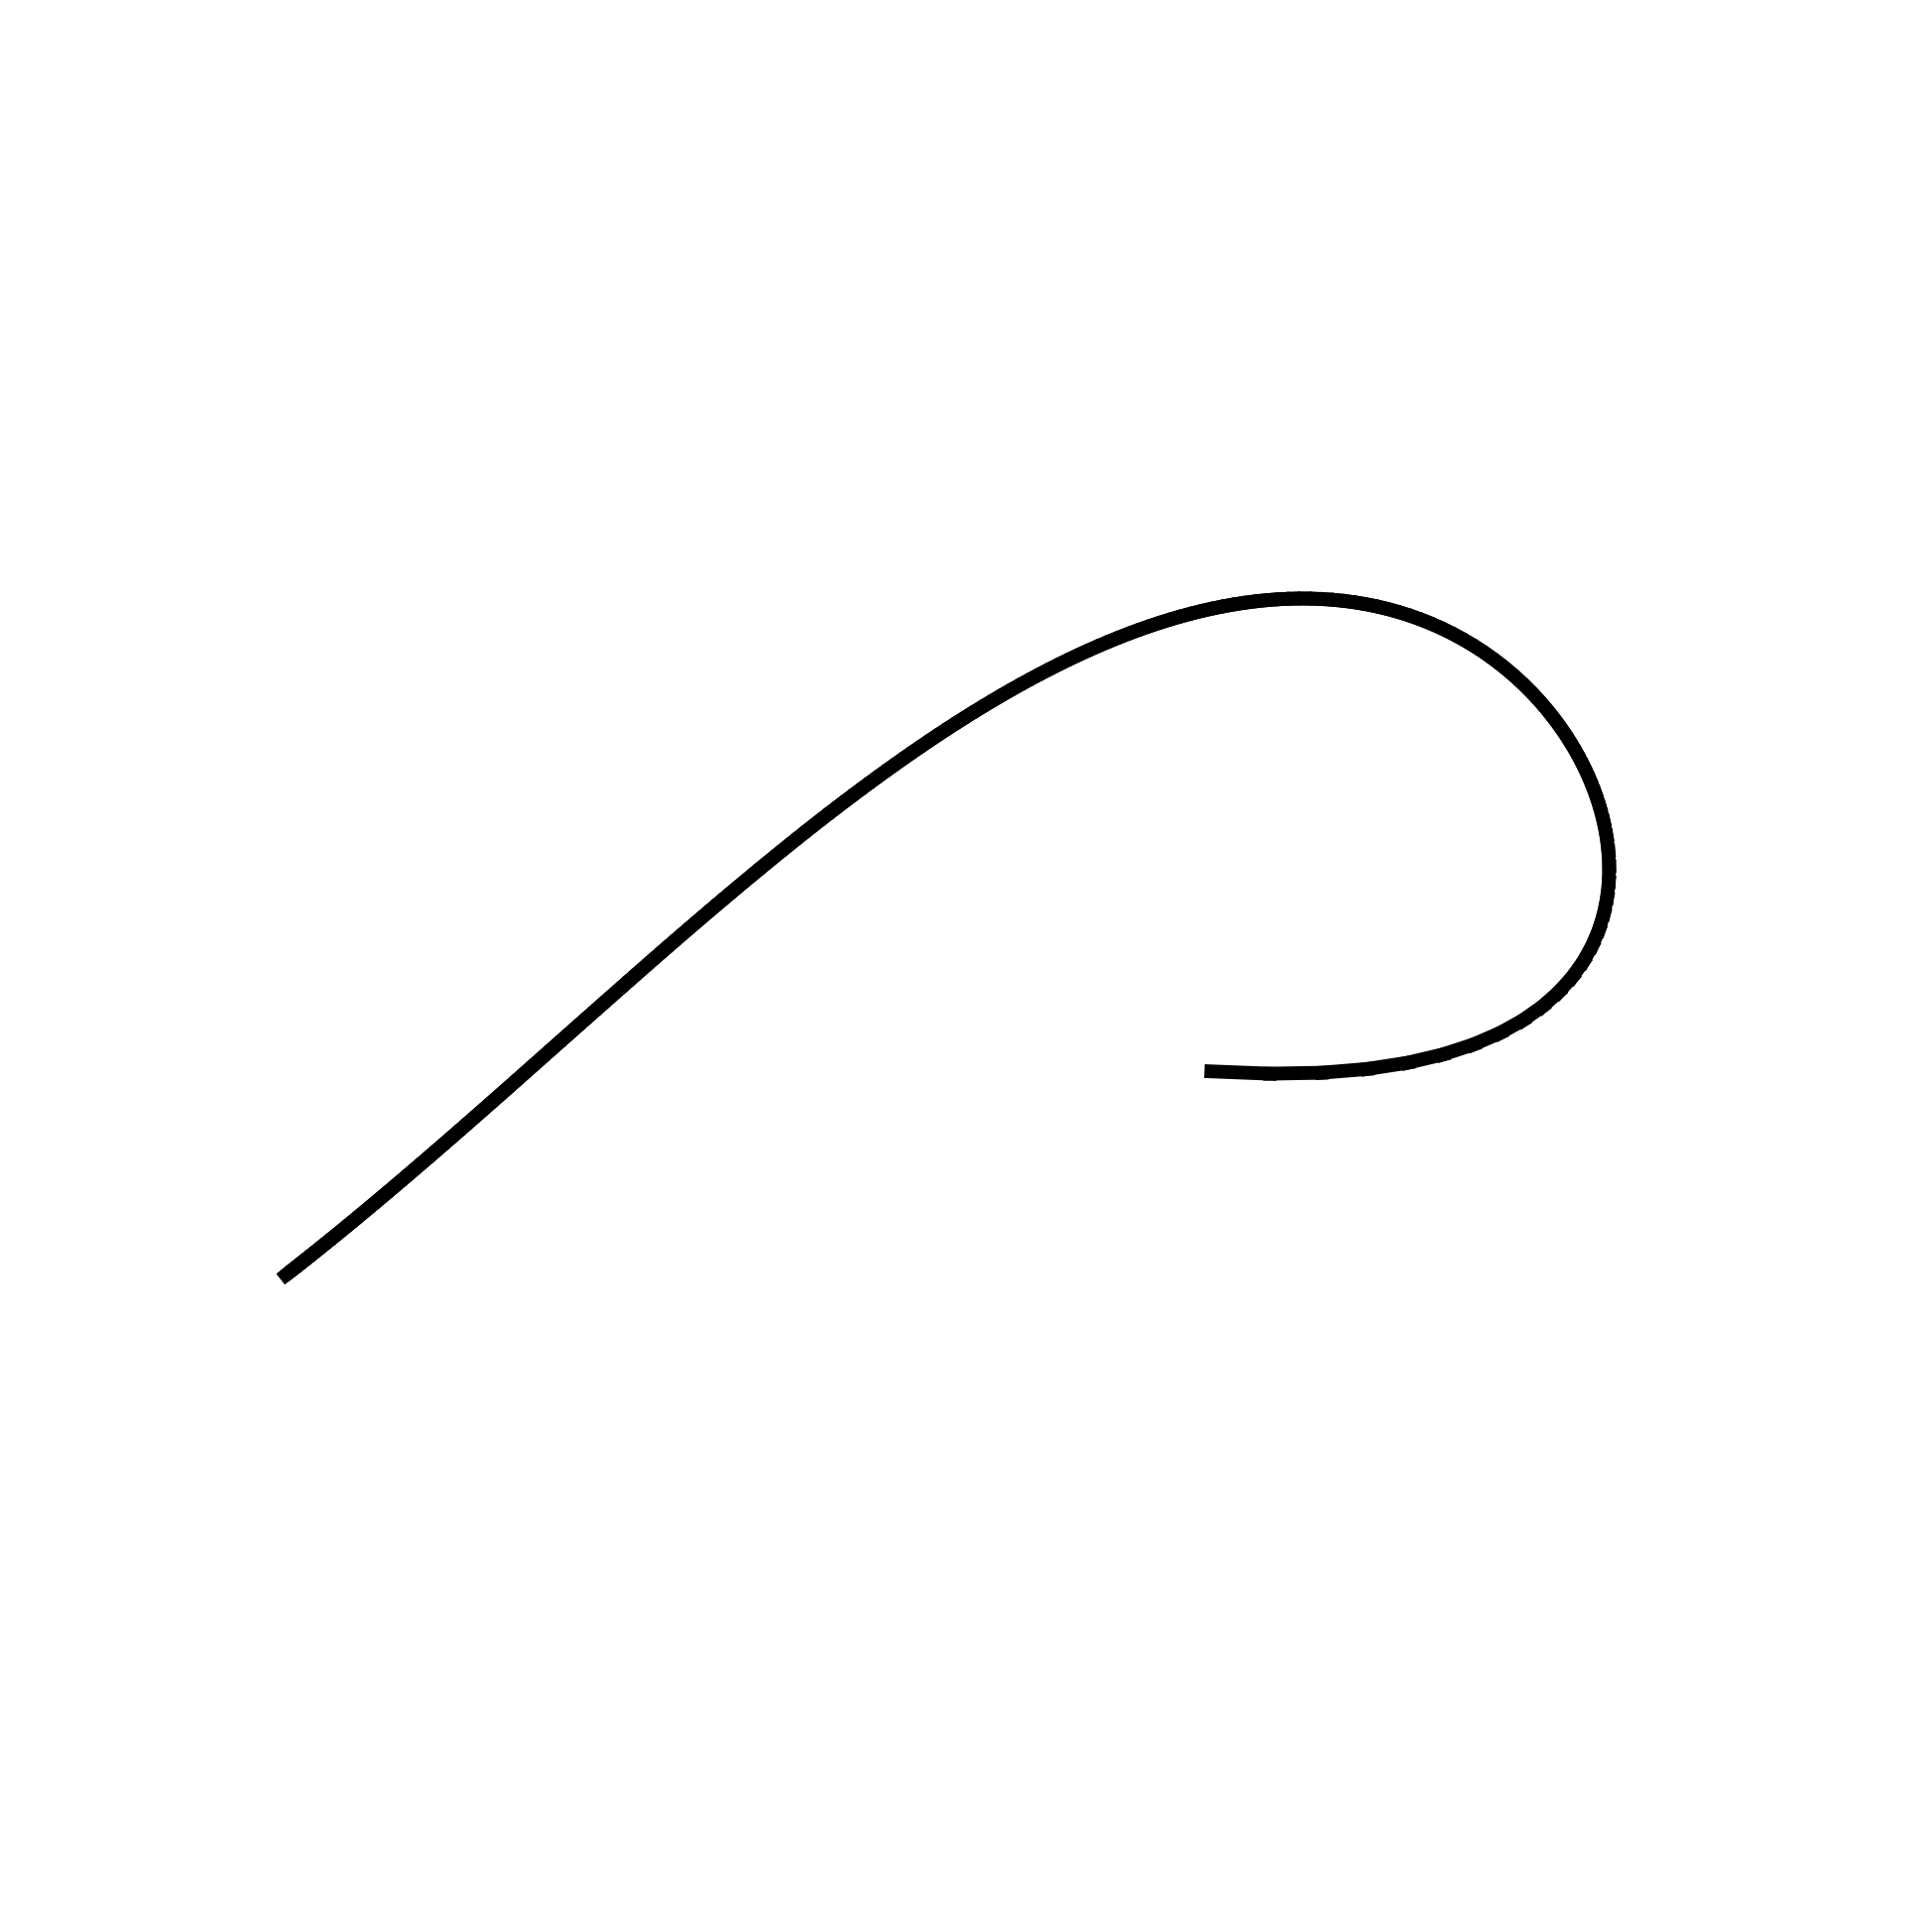

In [14]:
# Visualize the simulations model 1
visualize_simple([combined_simulations["curve"]["two_unstable_1"]["model2"][epoch][50] for epoch in ['epoch1','epoch2','epoch3']], color="black")

In [7]:
combined_simulations["curve"]["two_stable_0"]["model3"]["epoch1"].shape

(200, 200, 3)

### We now want to compare the dissimilarity matrices for the 3 networks

In [8]:
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_dsa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        print(f"pattern1: {pattern1}, pattern2: {pattern2}")
        dsa1vs2_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        vector_1vs2 = np.array([dsa1vs2_epoch1.fit_score(), dsa1vs2_epoch2.fit_score(), dsa1vs2_epoch3.fit_score()])
        vector_2vs3 = np.array([dsa2vs3_epoch1.fit_score(), dsa2vs3_epoch2.fit_score(), dsa2vs3_epoch3.fit_score()])
        vectors_dsa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_dsa[pattern1][pattern2]["vector2"] = vector_2vs3

pattern1: curve, pattern2: two_stable_0
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD compl

KeyboardInterrupt: 

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_pa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch1'], combined_simulations[pattern1][pattern2]['model2']['epoch1'])
        pa2vs3_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch1'], combined_simulations[pattern1][pattern2]['model3']['epoch1'])
        pa1vs2_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch2'], combined_simulations[pattern1][pattern2]['model2']['epoch2'])
        pa2vs3_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch2'], combined_simulations[pattern1][pattern2]['model3']['epoch2'])
        pa1vs2_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch3'], combined_simulations[pattern1][pattern2]['model2']['epoch3'])
        pa2vs3_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch3'], combined_simulations[pattern1][pattern2]['model3']['epoch3'])
        vector_1vs2 = 1-np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1-np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_pa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_pa[pattern1][pattern2]["vector2"] = vector_2vs3

In [ ]:
vectors_cka = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
        )
        pa2vs3_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
        )
        pa1vs2_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
        )
        pa2vs3_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
        )
        pa1vs2_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
        )
        pa2vs3_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
        )
        vector_1vs2 = 1 - np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1 - np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_cka[pattern1][pattern2]["vector1"] = vector_1vs2
        vectors_cka[pattern1][pattern2]["vector2"] = vector_2vs3

arccos score: 0.9996670724824976 0.02580488297194687 0.00033292751750235716
arccos score: 0.24271045920129897 1.3256374446749157 0.757289540798701
arccos score: 0.9999167739659028 0.012901719928100663 8.322603409716134e-05
arccos score: 0.644569977436101 0.8703356323131849 0.355430022563899
arccos score: 0.9999791966044115 0.006450343823259587 2.080339558852007e-05
arccos score: 0.9010125523849251 0.4486982575249656 0.09898744761507494
arccos score: 0.9996655264533153 0.02586473250484105 0.0003344735466846993
arccos score: 0.42995096755479234 1.126357858944416 0.5700490324452077
arccos score: 0.9999166966000546 0.012907715254622839 8.330339994544467e-05
arccos score: 0.7920662271878564 0.6566098806199214 0.20793377281214365
arccos score: 0.9999791915637118 0.00645112524351002 2.080843628815554e-05
arccos score: 0.9435153160323632 0.337711697171779 0.05648468396763684
arccos score: 0.9996697593070116 0.025700539724882128 0.00033024069298837055
arccos score: 0.778218954600459 0.678971605

In [ ]:
vectors_dsa_averaged = {'vector1':None, 'vector2':None}
vectors_dsa_sd = {'vector1':None, 'vector2':None}
vectors_pa_averaged = {'vector1':None, 'vector2':None}
vectors_pa_sd = {'vector1':None, 'vector2':None}
vectors_cka_averaged = {"vector1": None, "vector2": None}
vectors_cka_sd = {"vector1": None, "vector2": None}
for vector in vectors_dsa_averaged:
    vectors_dsa_averaged[vector] = np.mean([vectors_dsa[pattern1][pattern2][vector] for pattern1 in vectors_dsa for pattern2 in vectors_dsa[pattern1]], axis=0)
    vectors_dsa_sd[vector] = np.std(
        [
            vectors_dsa[pattern1][pattern2][vector]
            for pattern1 in vectors_dsa
            for pattern2 in vectors_dsa[pattern1]
        ],
        axis=0,
    ) / np.sqrt(
        len([
            vectors_dsa[pattern1][pattern2][vector]
            for pattern1 in vectors_dsa
            for pattern2 in vectors_dsa[pattern1]
        ])
    )
    vectors_pa_averaged[vector] = np.mean(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    )
    vectors_pa_sd[vector] = np.std(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    ) / np.sqrt(
        len([
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ])
    )
    vectors_cka_averaged[vector] = np.mean(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )
    vectors_cka_sd[vector] = np.std(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )/np.sqrt(
        len([
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ])
    )

In [ ]:
# save the vectors
np.save('../data/vectors_dsa_averaged.npy', vectors_dsa_averaged)
np.save('../data/vectors_dsa_sd.npy', vectors_dsa_sd)
np.save('../data/vectors_pa_averaged.npy', vectors_pa_averaged)
np.save('../data/vectors_pa_sd.npy', vectors_pa_sd)
np.save('../data/vectors_cka_averaged.npy', vectors_cka_averaged)
np.save('../data/vectors_cka_sd.npy', vectors_cka_sd)

In [ ]:
# load the vectors
vectors_dsa_averaged = np.load('../data/vectors_dsa_averaged.npy', allow_pickle=True).item()
vectors_dsa_sd = np.load('../data/vectors_dsa_sd.npy', allow_pickle=True).item()
vectors_pa_averaged = np.load('../data/vectors_pa_averaged.npy', allow_pickle=True).item()
vectors_pa_sd = np.load('../data/vectors_pa_sd.npy', allow_pickle=True).item()
vectors_cka_averaged = np.load('../data/vectors_cka_averaged.npy', allow_pickle=True).item()
vectors_cka_sd = np.load('../data/vectors_cka_sd.npy', allow_pickle=True).item()


R² for DSA: 0.982
Absolute gap for DSA: 0.025
R² for CKA: 0.964
Absolute gap for CKA: 0.018
R² for Procrustes: 0.964
Absolute gap for Procrustes: 0.016


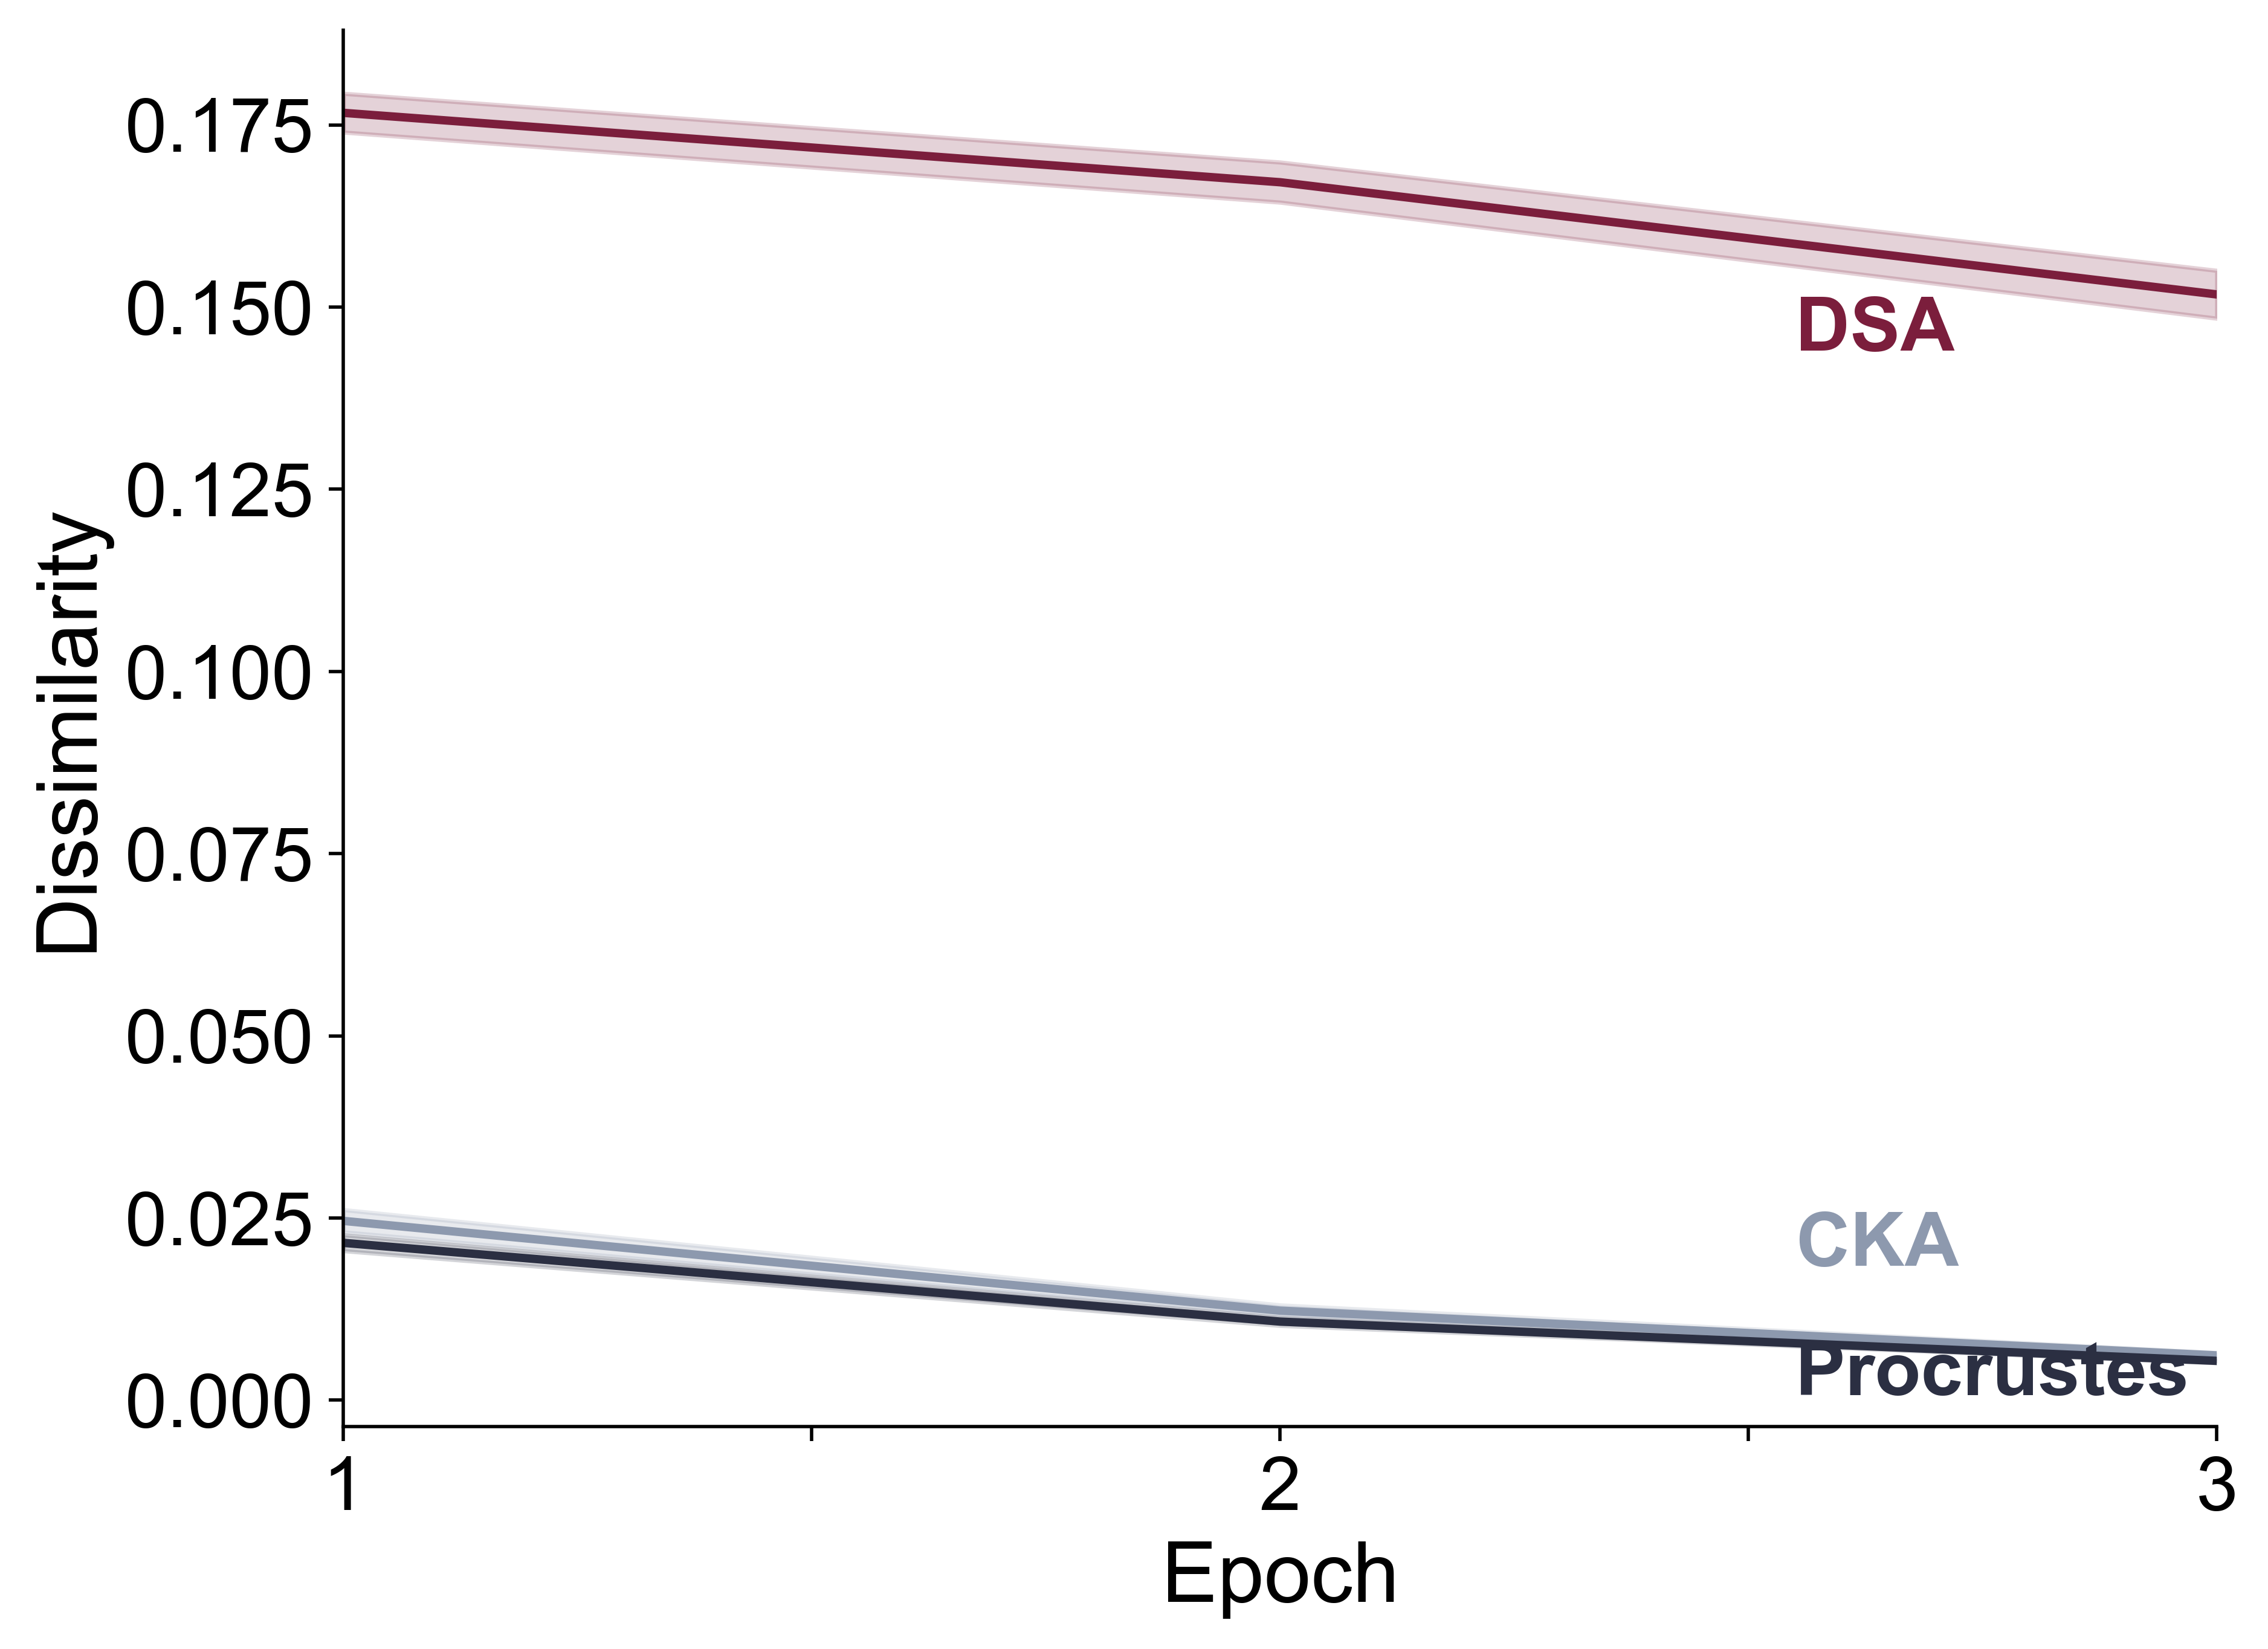

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3]).reshape(-1, 1)  # Reshape for sklearn

# Define color scheme
colors = ["#7B1E3C", "#8D99AE", "#2B2F42"]  # Greys for CKA and Procrustes, Red for DSA
r2_list = []
ygap_list = []
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=500)


# Function to calculate R² and plot curves with standard error shading and absolute gap
def plot_curve_with_r2_and_gap(components, y_values, y_errors, color, label):
    # Linear regression model
    model = LinearRegression()
    model.fit(components, y_values)

    # Predict values and calculate R²
    y_pred = model.predict(components)
    r2 = r2_score(y_values, y_pred)
    r2_list.append(r2)
    # Calculate absolute gap between the first and last y-value
    y_gap = abs(y_values[-1] - y_values[0])
    ygap_list.append(y_gap)
    # Print R² and absolute gap for each curve
    print(f"R² for {label}: {r2:.3f}")
    print(f"Absolute gap for {label}: {y_gap:.3f}")

    # Plot the curve
    ax.plot(
        components.flatten(),
        y_values,
        color=color,
        label=f"{label} (R²={r2:.2f}, Gap={y_gap:.2f})",
        linewidth=2,
    )

    # Fill between for standard error (shaded area)
    ax.fill_between(
        components.flatten(),
        y_values - y_errors,
        y_values + y_errors,
        color=color,
        alpha=0.2,  # Transparency of the shaded area
    )


# Plot curves for each measure with standard error shading
plot_curve_with_r2_and_gap(
    components,
    vectors_dsa_averaged["vector1"],
    vectors_dsa_sd["vector1"],
    colors[0],
    "DSA",
)
plot_curve_with_r2_and_gap(
    components,
    vectors_cka_averaged["vector1"],
    vectors_cka_sd["vector1"],
    colors[1],
    "CKA",
)
plot_curve_with_r2_and_gap(
    components,
    vectors_pa_averaged["vector1"],
    vectors_pa_sd["vector1"],
    colors[2],
    "Procrustes",
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [-0.005, 0.015, -0.002]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["DSA", "CKA", "Procrustes"], colors, vertical_offsets)
):
    x_last = components[-1, 0]
    y_last = [
        vectors_dsa_averaged["vector1"][-1],
        vectors_cka_averaged["vector1"][-1],
        vectors_pa_averaged["vector1"][-1],
    ][i]
    ax.text(
        x_last * 0.85,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_xlim(1, 3)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1, 1.5, 2, 2.5, 3])
ax.set_xticklabels(["1", "", "2", "", "3"])

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=500)
plt.show()

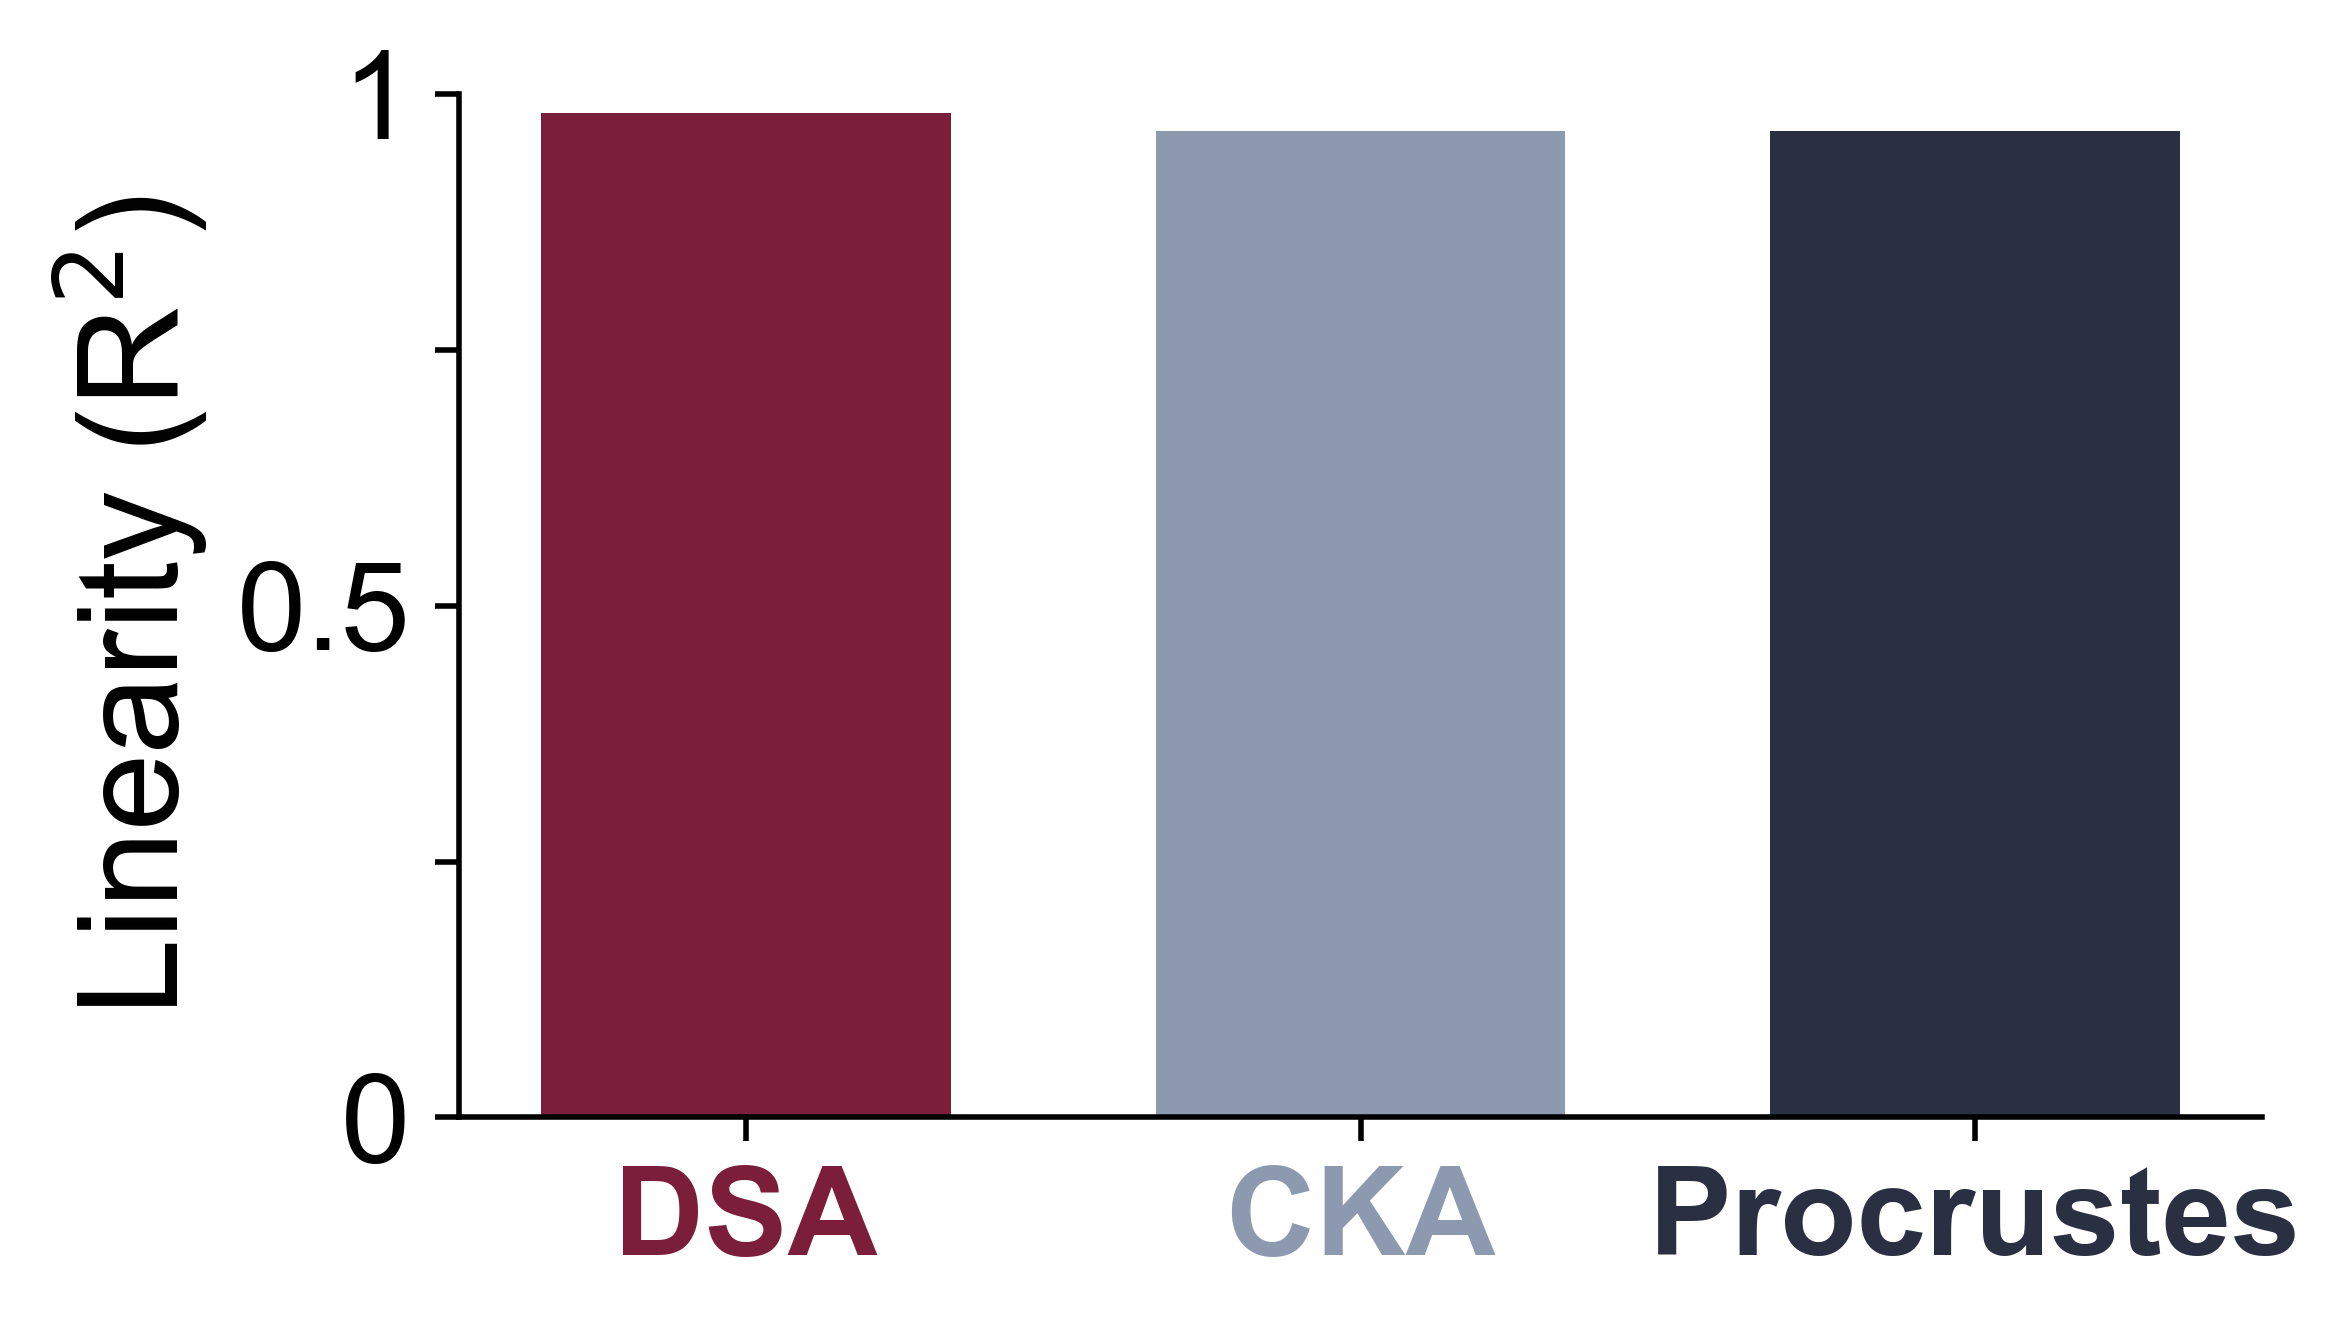

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Explicitly disable LaTeX
plt.rcParams["text.usetex"] = False

# Data
metrics = ["DSA", "CKA", "Procrustes"]
values = r2_list  # Assuming r2_list is defined elsewhere in your code

# Color mapping
color_mapping_metrics = {
    "dsa": "#7B1E3C",
    "cka": "#8D99AE",
    "procrustes": "#2B2F42",
}

# Create the bar chart
fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

x_positions = np.arange(len(metrics)) * 3

# Plot bars
bars = ax.bar(
    x_positions,
    values,
    width=2,
    color=[color_mapping_metrics[m.lower()] for m in metrics],
)

# Customize the chart
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # Set y-axis limits
ax.set_ylabel("Linearity (R$^2$)")  # Set y-axis label with mathtext superscript
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "", "0.5", "", "1"])

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Color the x-axis labels (metric names) with corresponding colors and make them bold
for tick, metric in zip(ax.get_xticklabels(), metrics):
    tick.set_color(color_mapping_metrics[metric.lower()])
    tick.set_fontweight("bold")

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

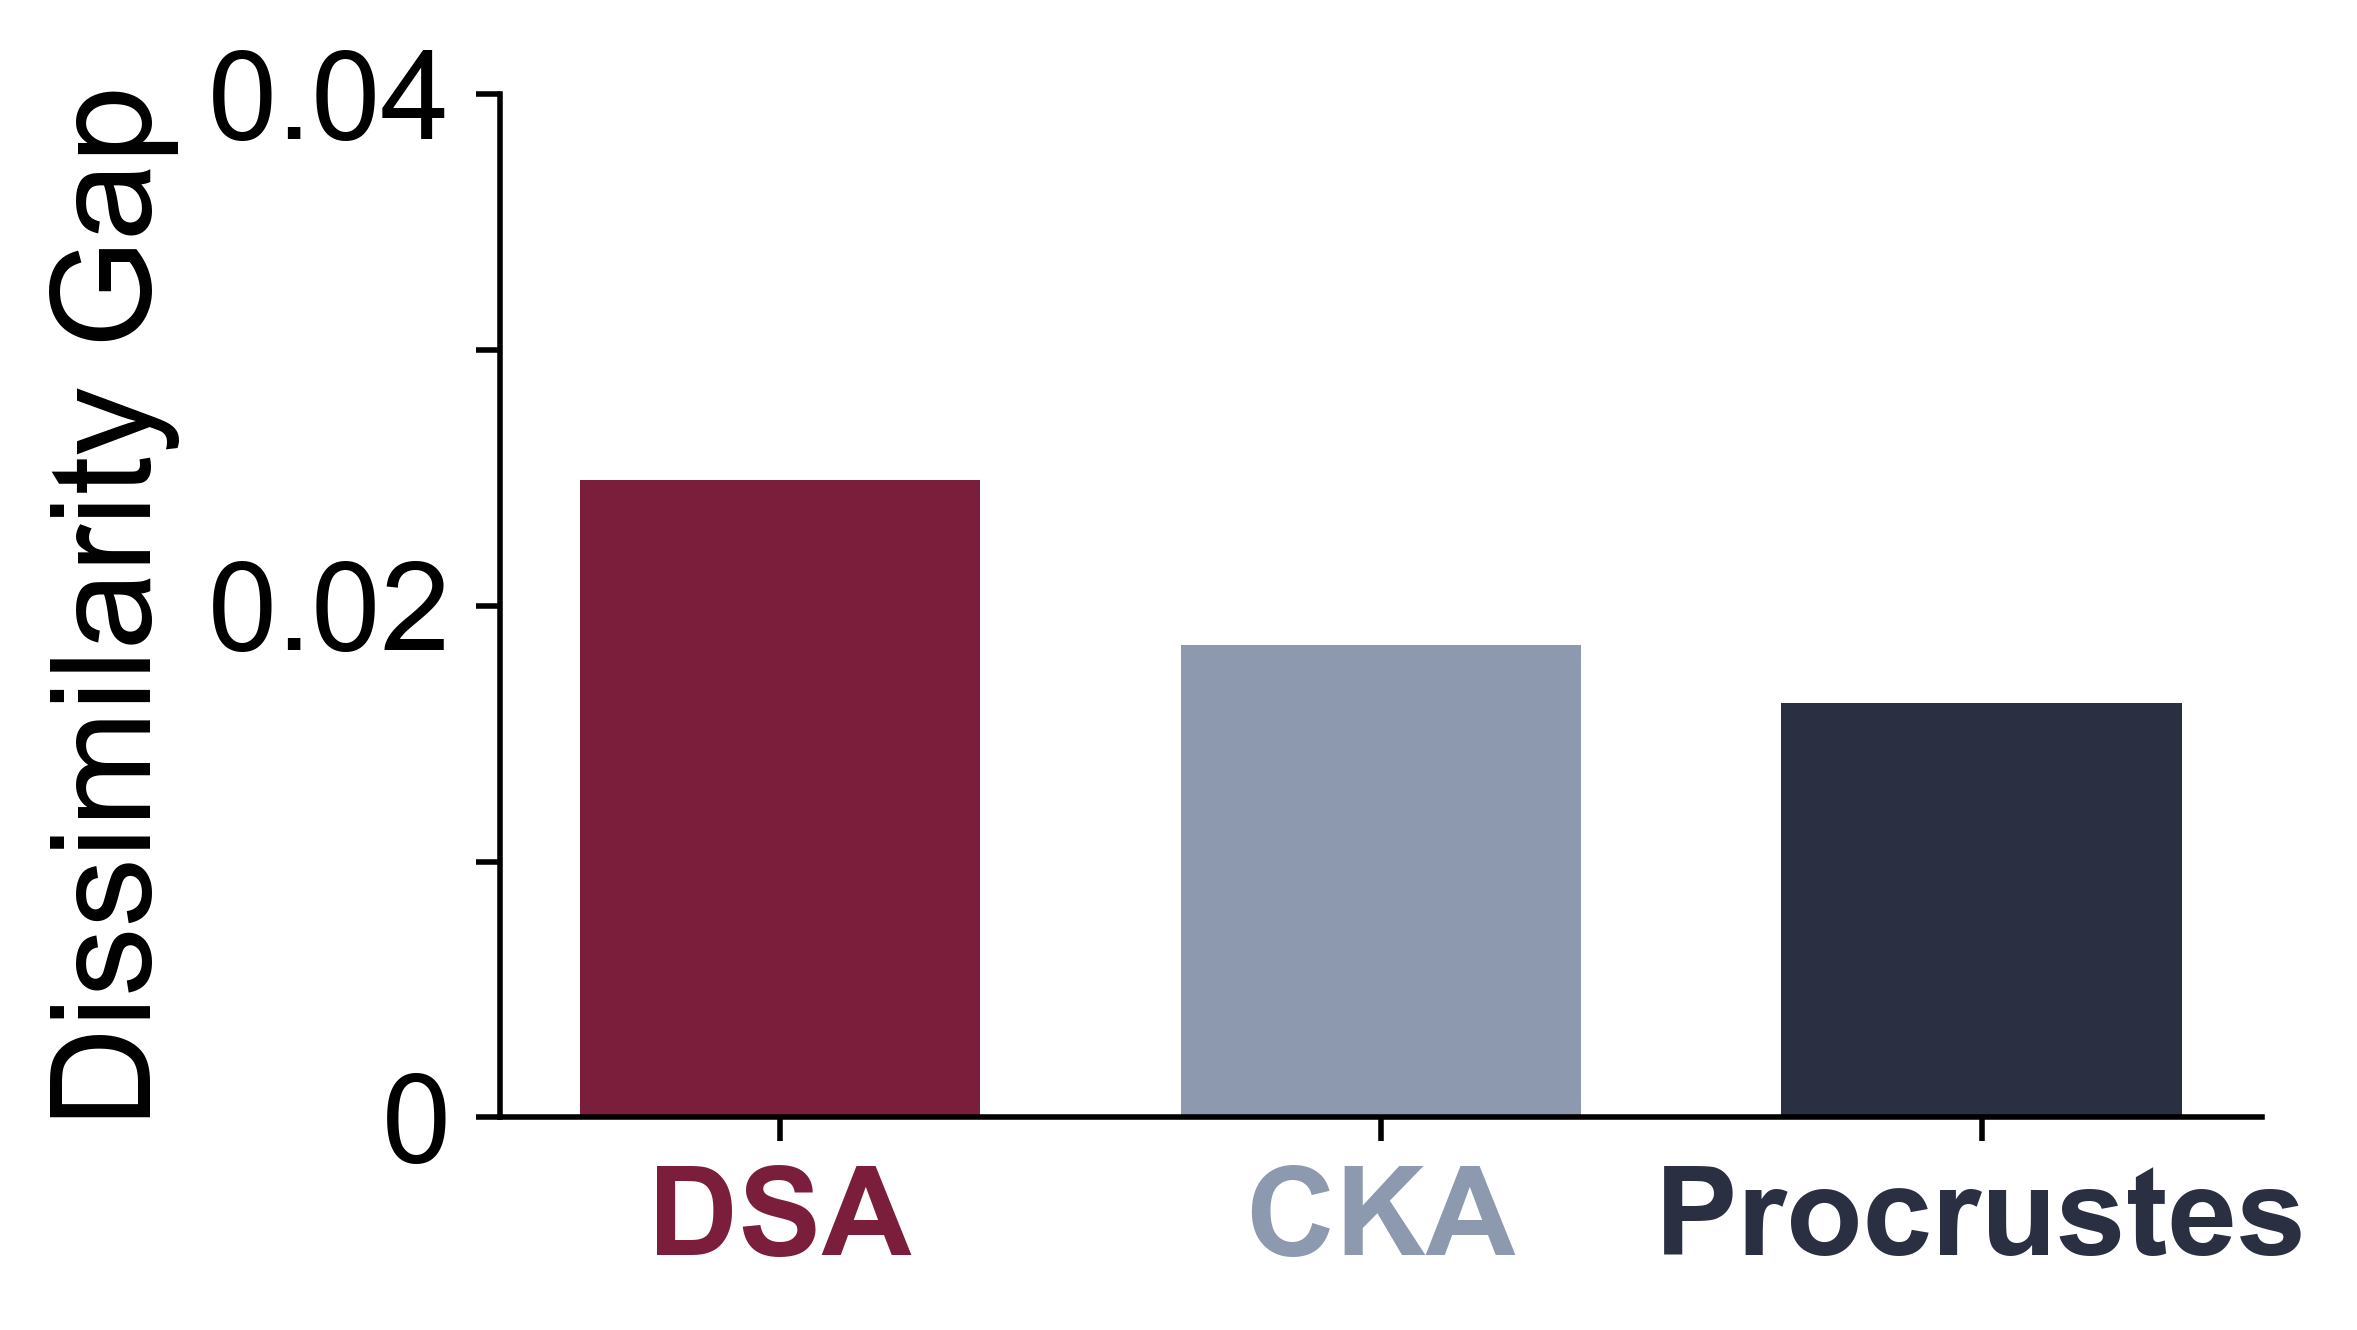

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Explicitly disable LaTeX
plt.rcParams["text.usetex"] = False

# Data
metrics = ["DSA", "CKA", "Procrustes"]
values = ygap_list  # Assuming r2_list is defined elsewhere in your code

# Color mapping
color_mapping_metrics = {
    "dsa": "#7B1E3C",
    "cka": "#8D99AE",
    "procrustes": "#2B2F42",
}

# Create the bar chart
fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

x_positions = np.arange(len(metrics)) * 3
# Plot bars
bars = ax.bar(
    x_positions, values, width=2, color=[color_mapping_metrics[m.lower()] for m in metrics]
)

# Customize the chart
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics)
ax.set_ylim(0, max(ygap_list))  # Set y-axis limits
ax.set_ylabel("Dissimilarity Gap")  # Set y-axis label with mathtext superscript

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
ax.set_yticklabels(["0", "", "0.02", "", "0.04"])

# Color the x-axis labels (metric names) with corresponding colors
for tick, metric in zip(ax.get_xticklabels(), metrics):
    tick.set_color(color_mapping_metrics[metric.lower()])
    tick.set_fontweight("bold")  # Make the labels bold

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

R² for DSA: 1.000, Y-axis Gap: 0.056
R² for CKA: 0.999, Y-axis Gap: 0.337
R² for Procrustes: 0.997, Y-axis Gap: 0.287


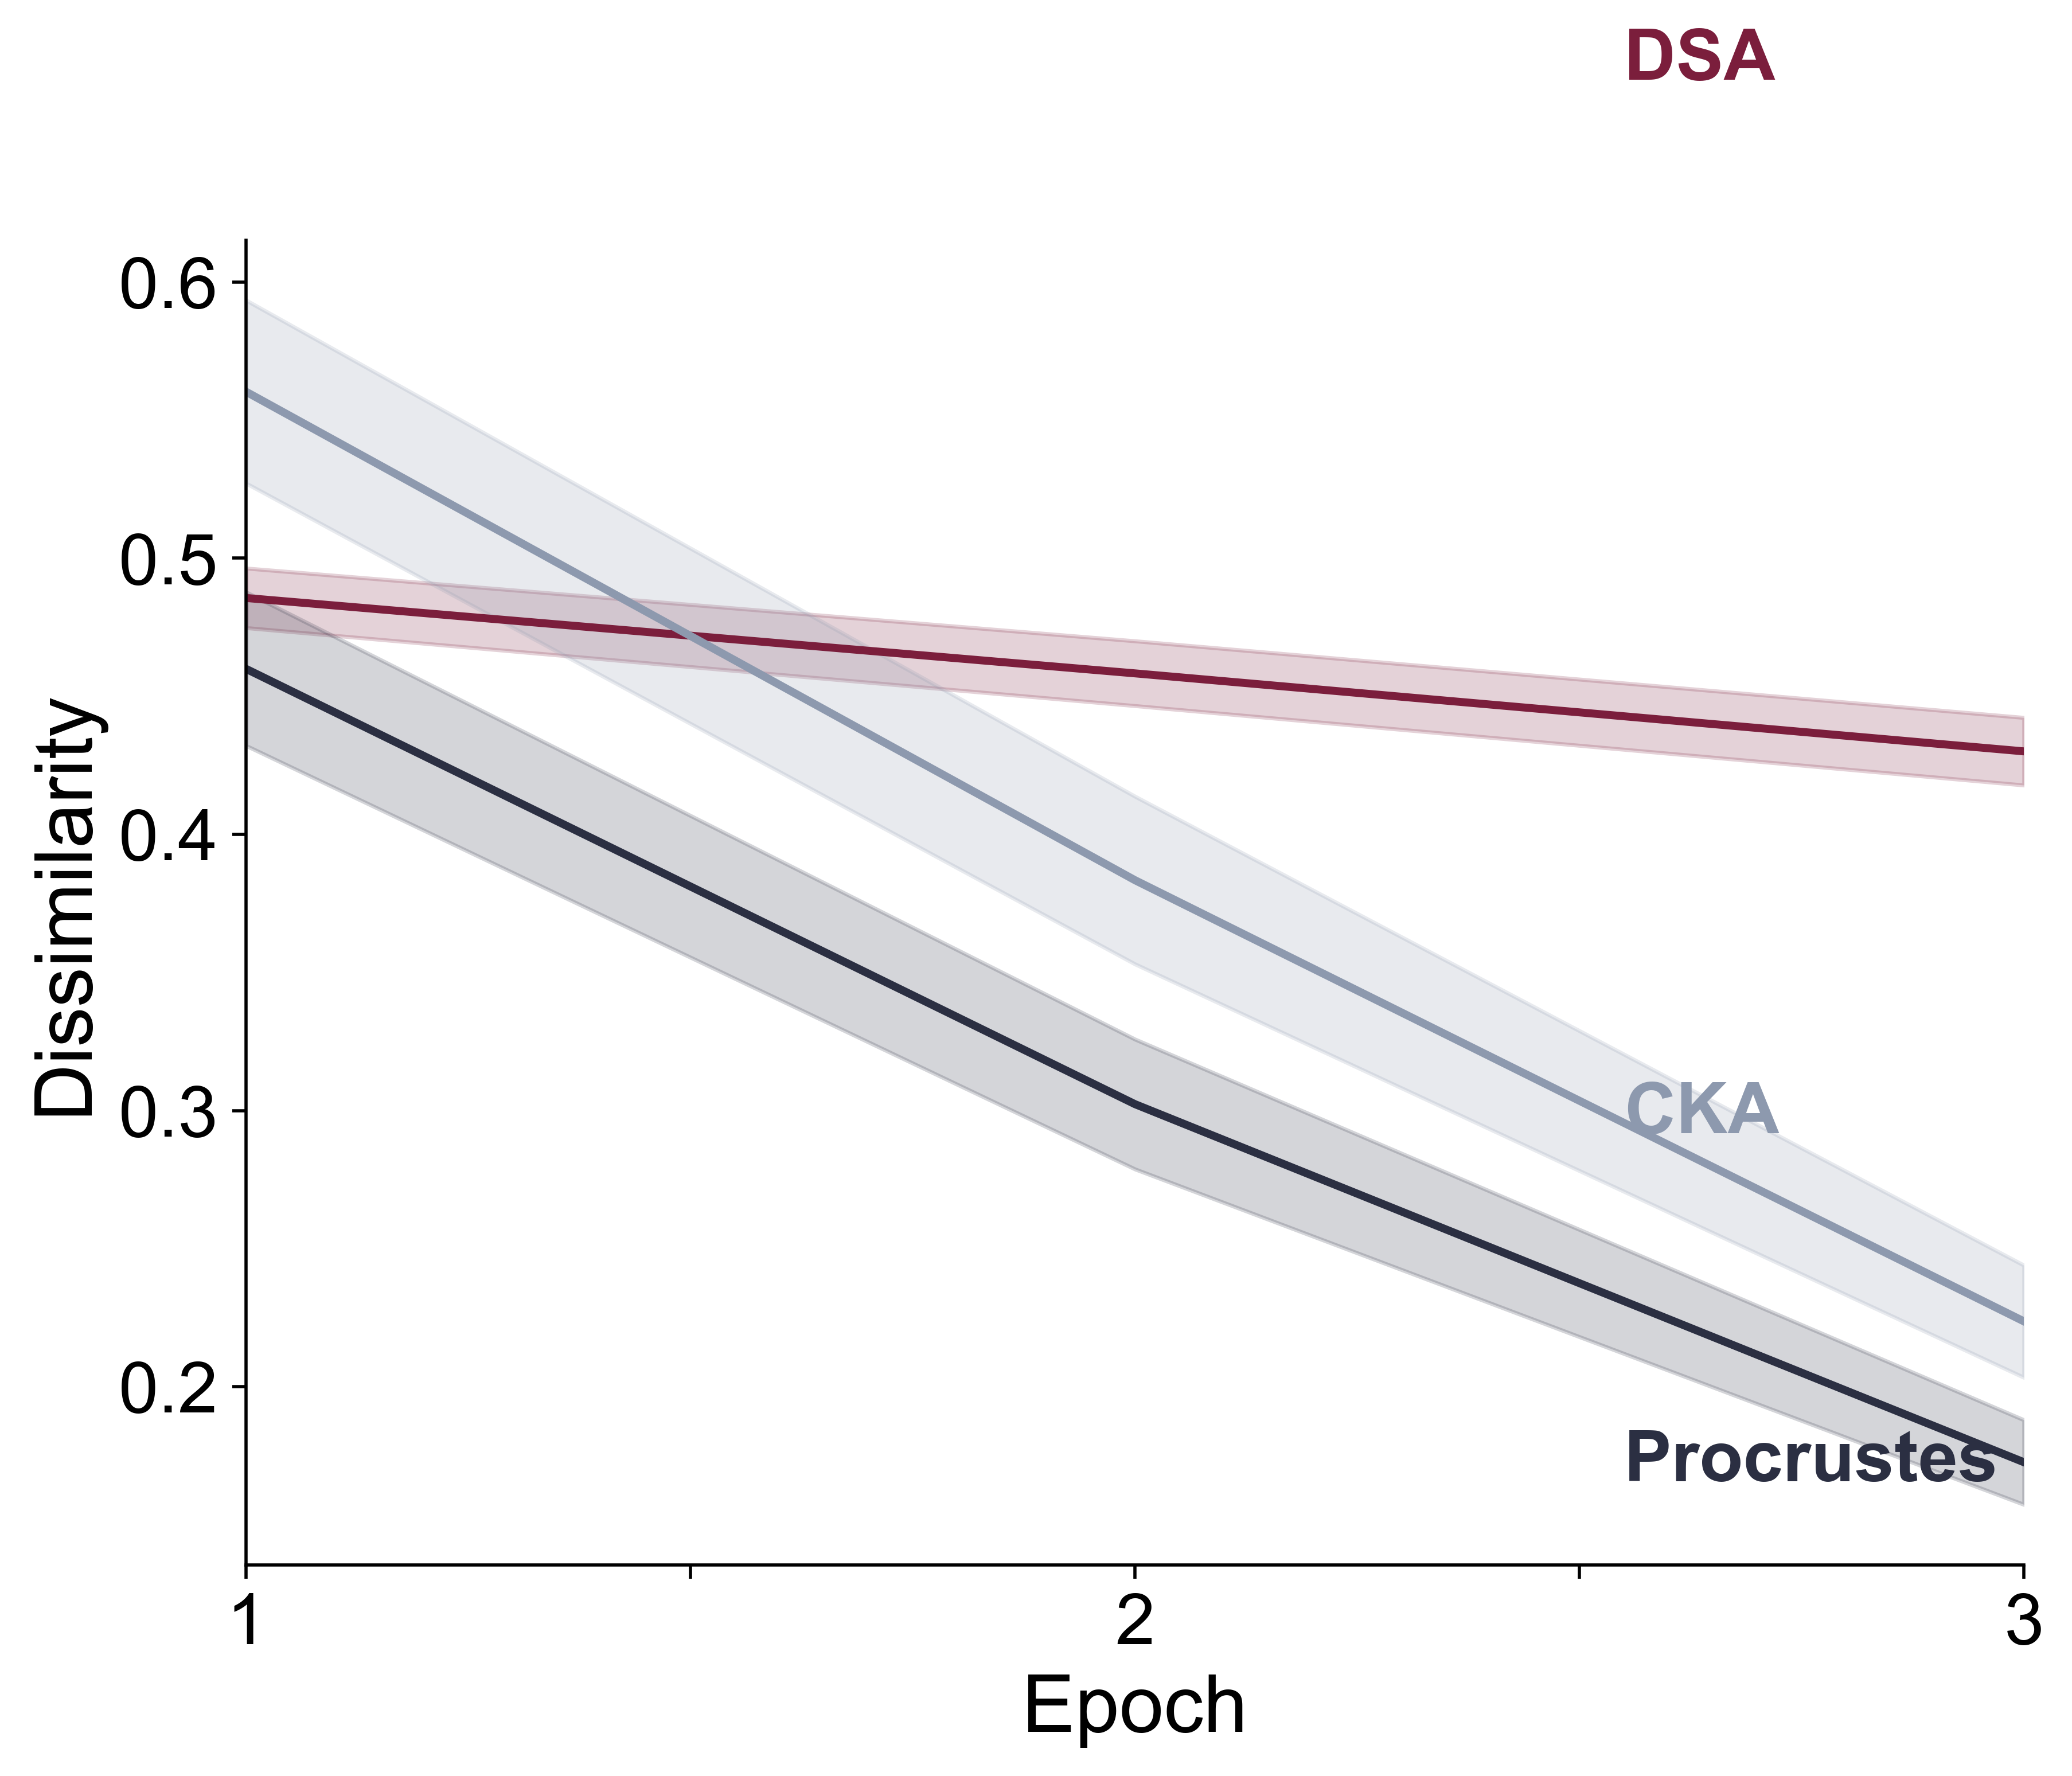

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3]).reshape(-1, 1)  # Reshape for sklearn

# Define color scheme
colors = ["#7B1E3C", "#8D99AE", "#2B2F42"]  # Greys for CKA and Procrustes, Red for DSA

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=500)
r2_list = []
ygap_list = []

# Function to calculate R², y-axis distance measure and plot curves with standard error shading
def plot_curve_with_metrics(components, y_values, y_errors, color, label):
    # Linear regression model
    model = LinearRegression()
    model.fit(components, y_values)

    # Predict values and calculate R²
    y_pred = model.predict(components)
    r2 = r2_score(y_values, y_pred)
    r2_list.append(r2)

    # Calculate the absolute gap between the last and first y-values
    y_gap = abs(y_values[-1] - y_values[0])
    ygap_list.append(y_gap)
    print(f"R² for {label}: {r2:.3f}, Y-axis Gap: {y_gap:.3f}")

    # Plot the curve
    ax.plot(
        components,
        y_values,
        color=color,
        label=f"{label} (R²={r2:.2f}, Gap={y_gap:.2f})",
        linewidth=2,
    )

    # Fill between for standard error (shaded area)
    ax.fill_between(
        components.flatten(),
        y_values - y_errors,
        y_values + y_errors,
        color=color,
        alpha=0.2,  # Transparency of the shaded area
    )


# Plot curves for each measure with standard error shading
plot_curve_with_metrics(
    components,
    vectors_dsa_averaged["vector2"],
    vectors_dsa_sd["vector2"],
    colors[0],
    "DSA",
)
plot_curve_with_metrics(
    components,
    vectors_cka_averaged["vector2"],
    vectors_cka_sd["vector2"],
    colors[1],
    "CKA",
)
plot_curve_with_metrics(
    components,
    vectors_pa_averaged["vector2"],
    vectors_pa_sd["vector2"],
    colors[2],
    "Procrustes",
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0.25, 0.075, 0]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["DSA", "CKA", "Procrustes"], colors, vertical_offsets)
):
    x_last = components[-1, 0]
    y_last = [
        vectors_dsa_averaged["vector2"][-1],
        vectors_cka_averaged["vector2"][-1],
        vectors_pa_averaged["vector2"][-1],
    ][i]
    ax.text(
        x_last * 0.85,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_xlim(1, 3)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1, 1.5, 2, 2.5, 3])
ax.set_xticklabels(["1", "", "2", "", "3"])

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

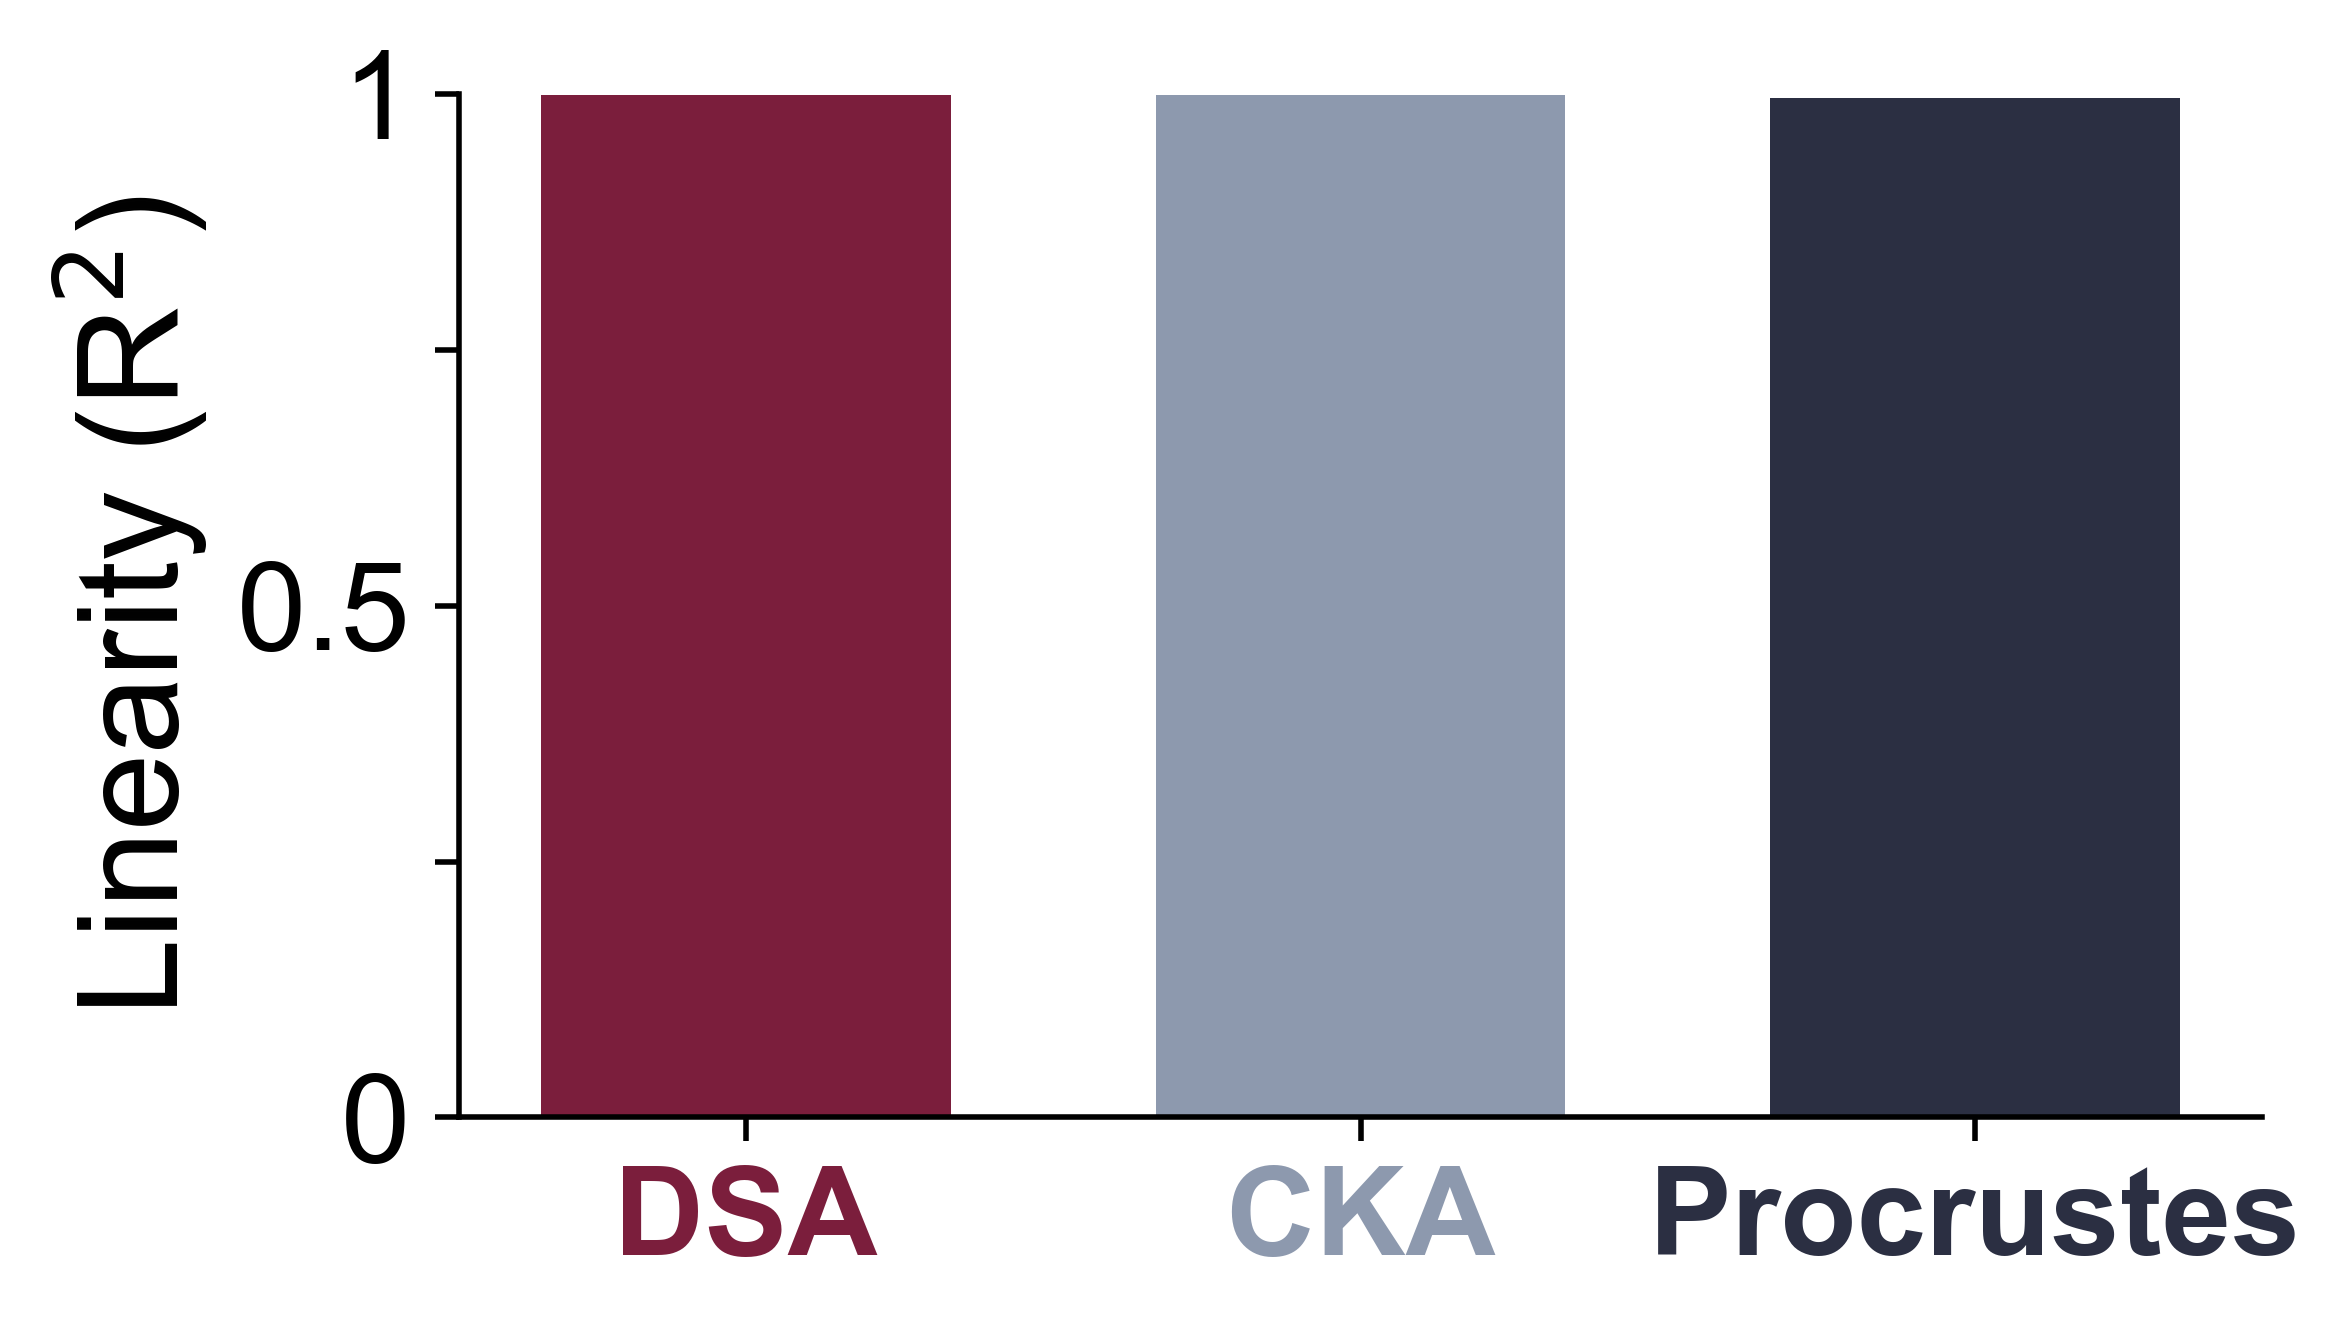

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Explicitly disable LaTeX
plt.rcParams["text.usetex"] = False

# Data
metrics = ["DSA", "CKA", "Procrustes"]
values = r2_list  # Assuming r2_list is defined elsewhere in your code

# Color mapping
color_mapping_metrics = {
    "dsa": "#7B1E3C",
    "cka": "#8D99AE",
    "procrustes": "#2B2F42",
}

# Create the bar chart
fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

x_positions = np.arange(len(metrics)) * 3

# Plot bars
bars = ax.bar(
    x_positions,
    values,
    width=2,
    color=[color_mapping_metrics[m.lower()] for m in metrics],
)

# Customize the chart
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # Set y-axis limits
ax.set_ylabel("Linearity (R$^2$)")  # Set y-axis label with mathtext superscript
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "", "0.5", "", "1"])

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Color the x-axis labels (metric names) with corresponding colors
for tick, metric in zip(ax.get_xticklabels(), metrics):
    tick.set_color(color_mapping_metrics[metric.lower()])
    tick.set_fontweight("bold")  # Make the labels bold

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

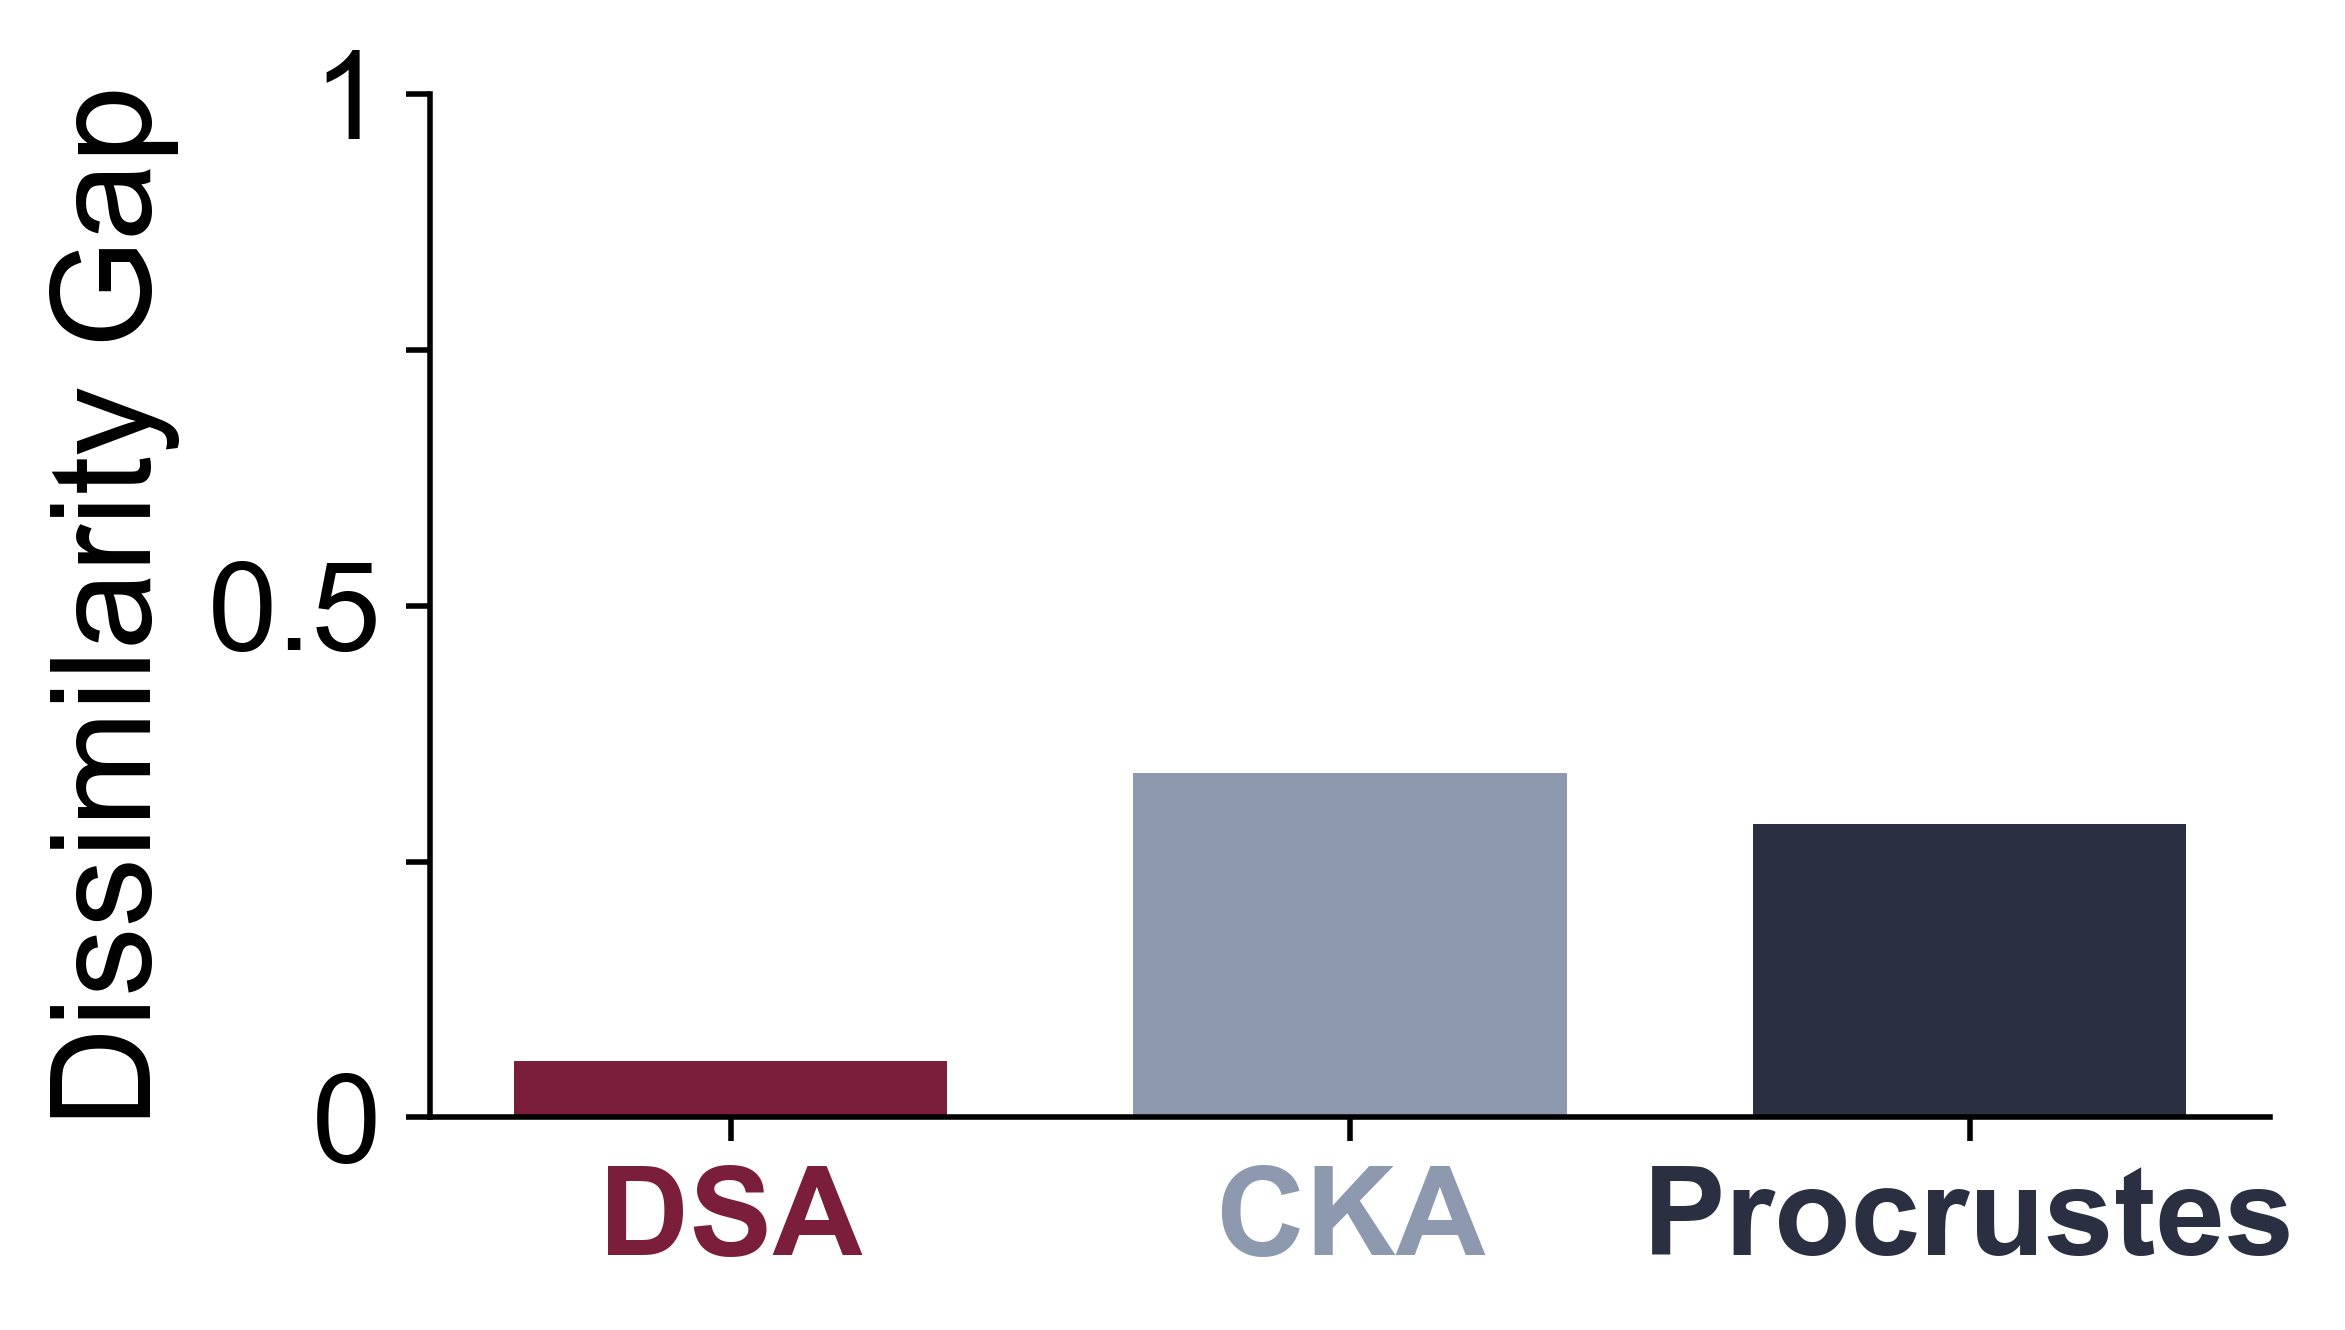

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Explicitly disable LaTeX
plt.rcParams["text.usetex"] = False

# Data
metrics = ["DSA", "CKA", "Procrustes"]
values = ygap_list  # Assuming r2_list is defined elsewhere in your code

# Color mapping
color_mapping_metrics = {
    "dsa": "#7B1E3C",
    "cka": "#8D99AE",
    "procrustes": "#2B2F42",
}

# Create the bar chart
fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

# Plot bars
bars = ax.bar(
    metrics, values, color=[color_mapping_metrics[m.lower()] for m in metrics], width=0.7
)

# Customize the chart
ax.set_ylim(0, max(ygap_list))  # Set y-axis limits
ax.set_ylabel("Dissimilarity Gap")  # Set y-axis label with mathtext superscript

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "", "0.5", "", "1"])

# Color the x-axis labels (metric names) with corresponding colors
for tick, metric in zip(ax.get_xticklabels(), metrics):
    tick.set_color(color_mapping_metrics[metric.lower()])
    tick.set_fontweight("bold")  # Make the labels bold

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 